# Poisson HMM on example session

In [1]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import pandas as pd

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from dynamax.hidden_markov_model import PoissonHMM


# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
from fitting_functions import cross_validate_poismodel

one = ONE(mode='remote')

## Parameters

In [2]:
# Parameters
bin_size = 0.017
multiplier=1
num_states = 2
num_iters = 100
num_train_batches = 5
threshold = 0.05
sticky = False

# LOAD DATA
cv_results_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
data_path ='/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
grid_search_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/grid_search/individual_sessions/'

all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

use_sets = [['avg_wheel_vel'], ['whisker_me'], ['Lick count'], ['0.25', '0.5',
    '1.0', '2.0', '4.0', '8.0', '16.0']]
var_interest_map = ['avg_wheel_vel', 'whisker_me', 'Lick count', 'wavelet']
idx_init_list = [0, 1, 2, 3]
idx_end_list = [1, 2, 3, 10]

var_interest = 'Lick count'


# Sessions with cross-validated results

In [4]:
# Identify sessions availableto process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    result_filename = os.path.join(cv_results_path  + "most_likely_states" + var_interest + '_' + fit_id)
    if os.path.exists(result_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 73 sessions to process.


# Fit best params on individual sessions

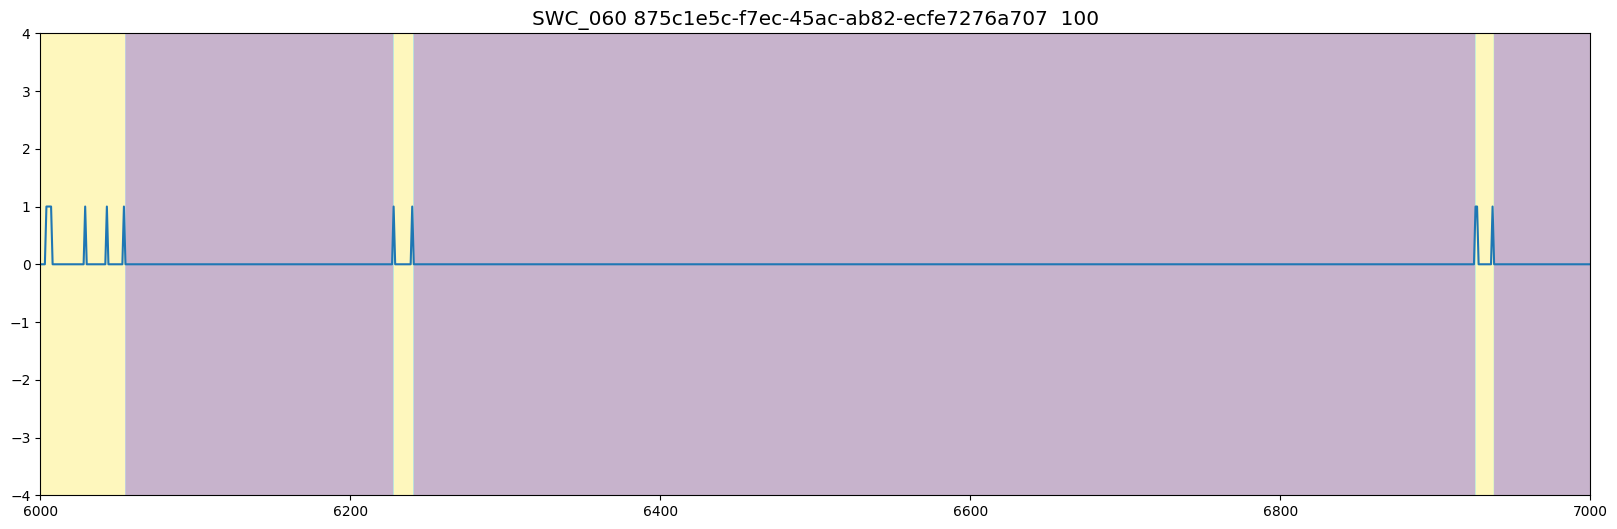

SWC_060875c1e5c-f7ec-45ac-ab82-ecfe7276a707


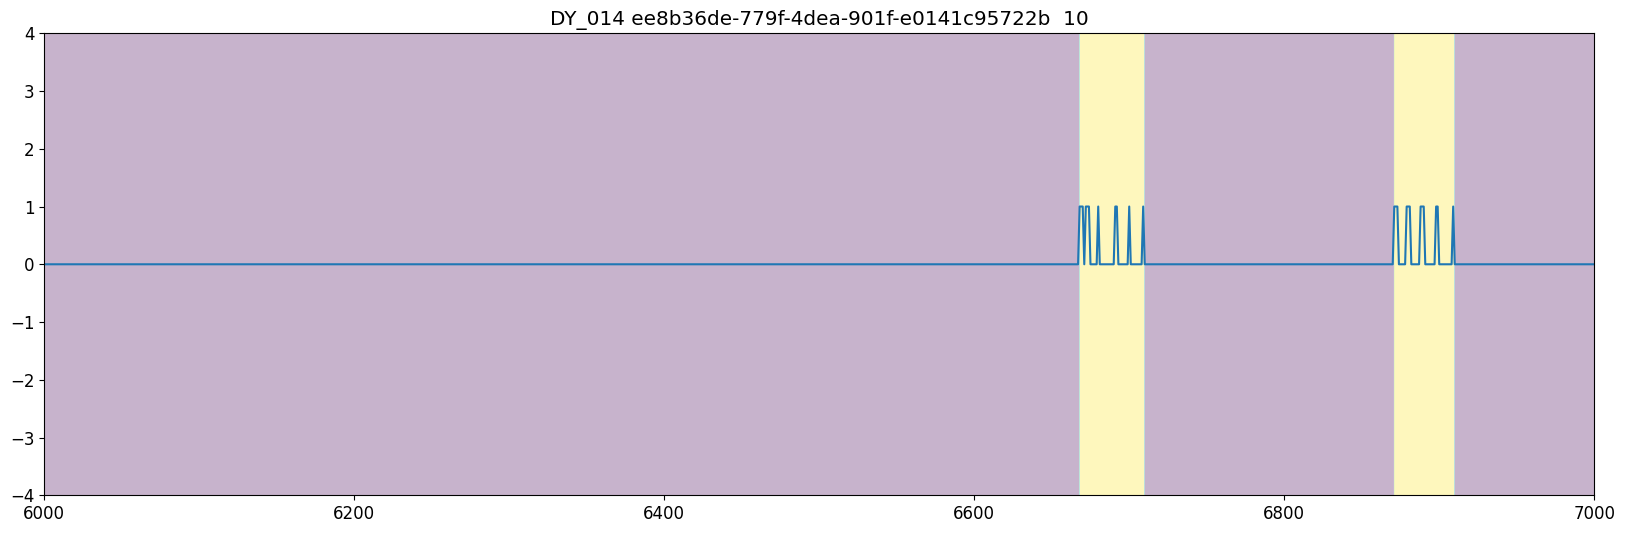

DY_014ee8b36de-779f-4dea-901f-e0141c95722b


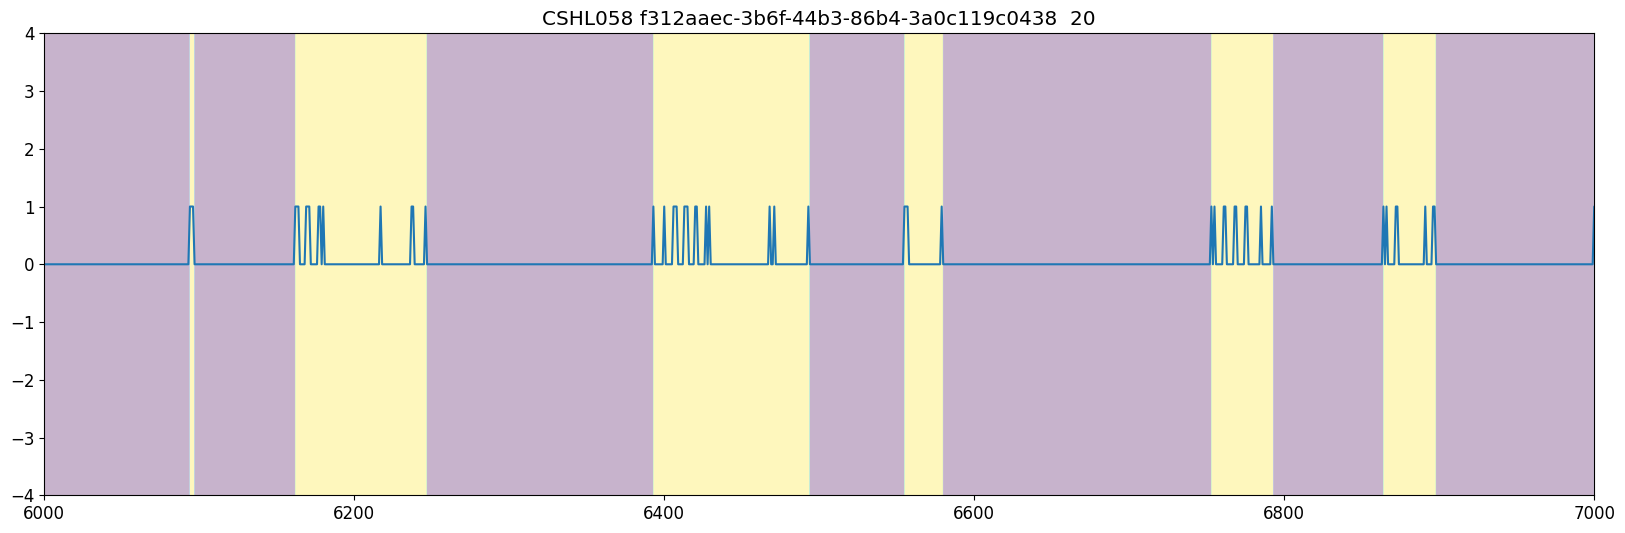

CSHL058f312aaec-3b6f-44b3-86b4-3a0c119c0438


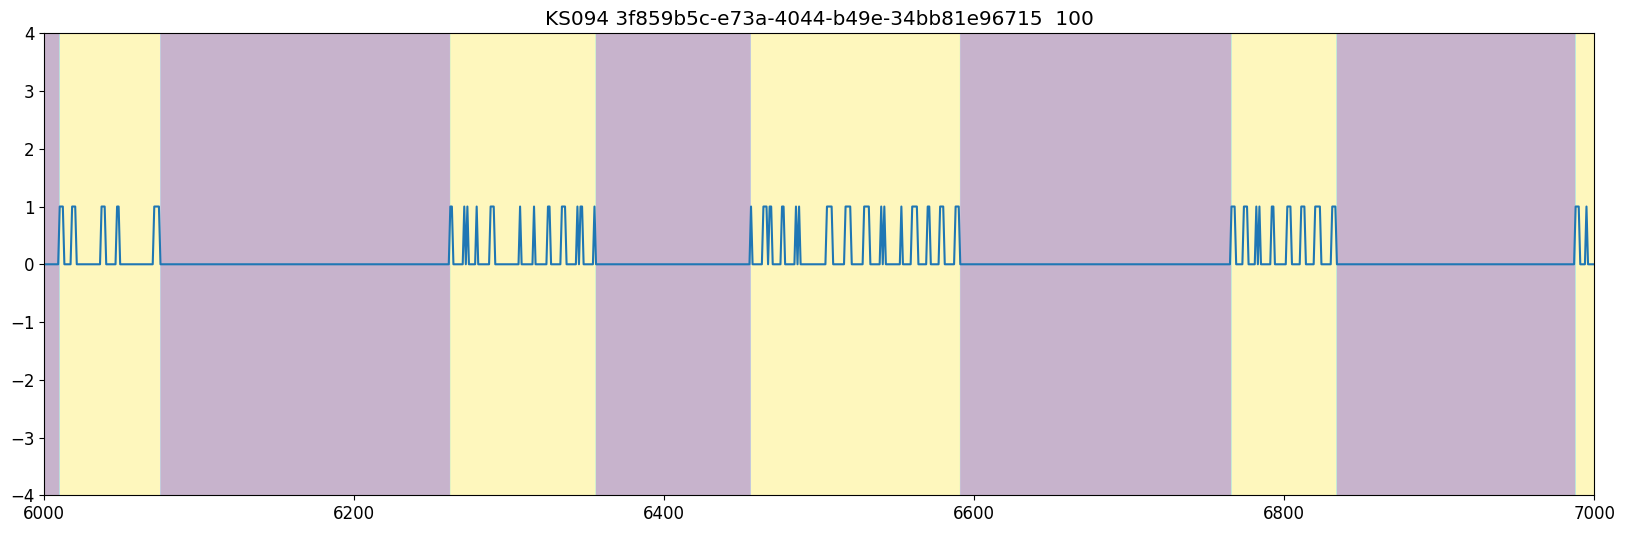

KS0943f859b5c-e73a-4044-b49e-34bb81e96715


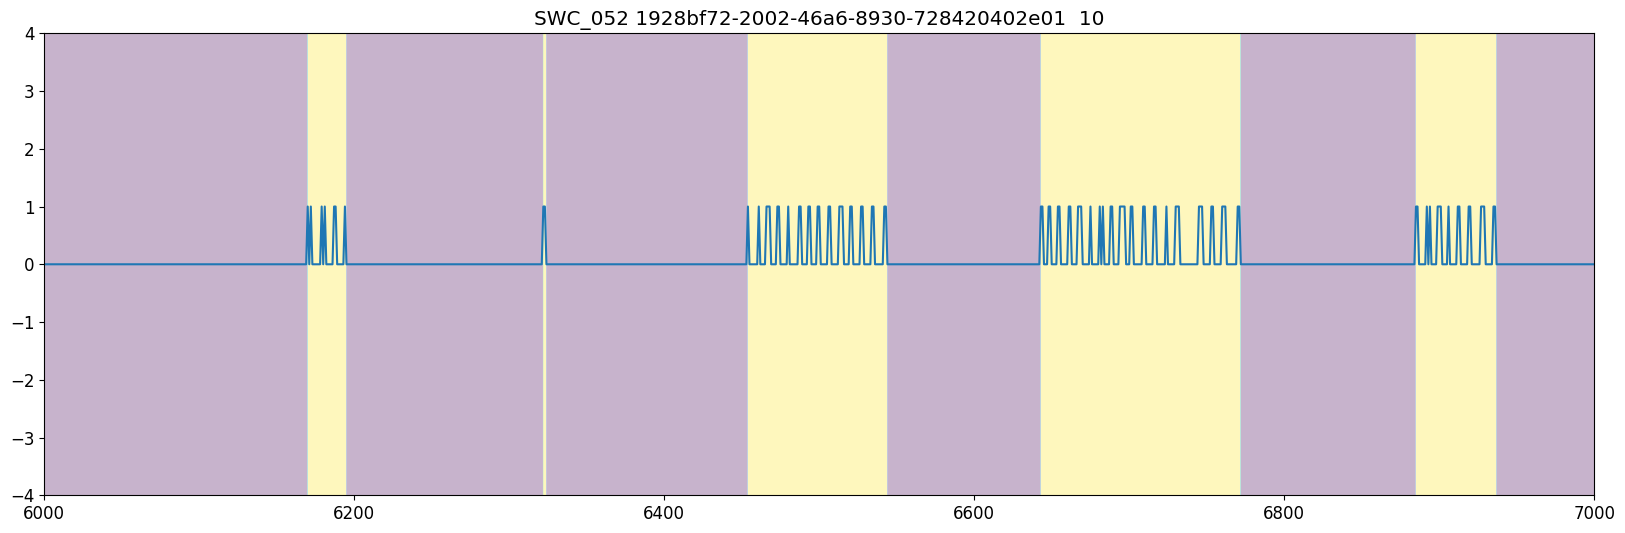

SWC_0521928bf72-2002-46a6-8930-728420402e01


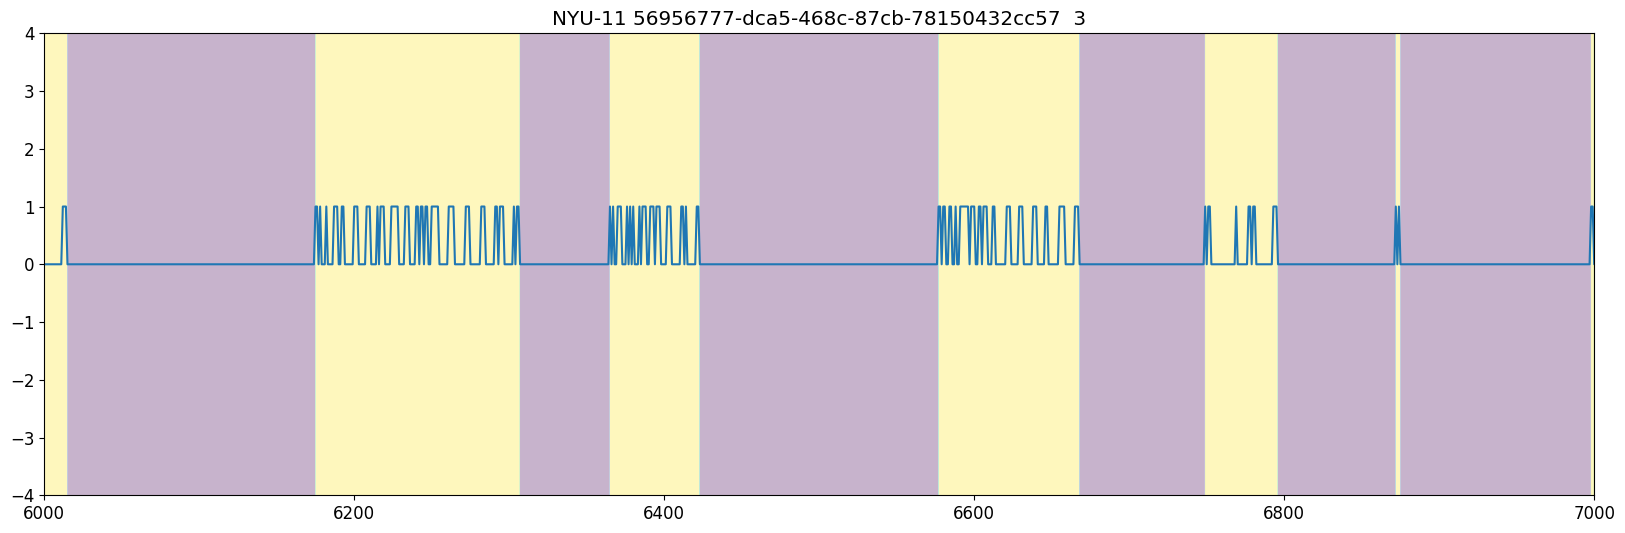

NYU-1156956777-dca5-468c-87cb-78150432cc57


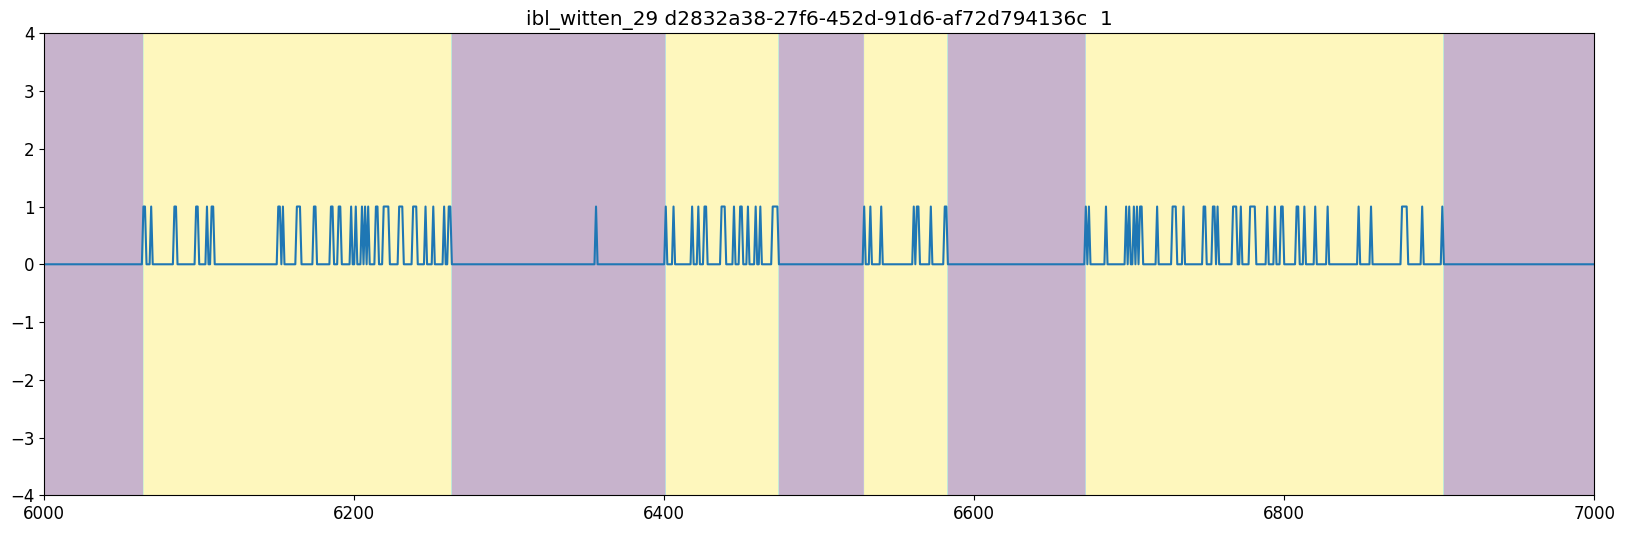

ibl_witten_29d2832a38-27f6-452d-91d6-af72d794136c


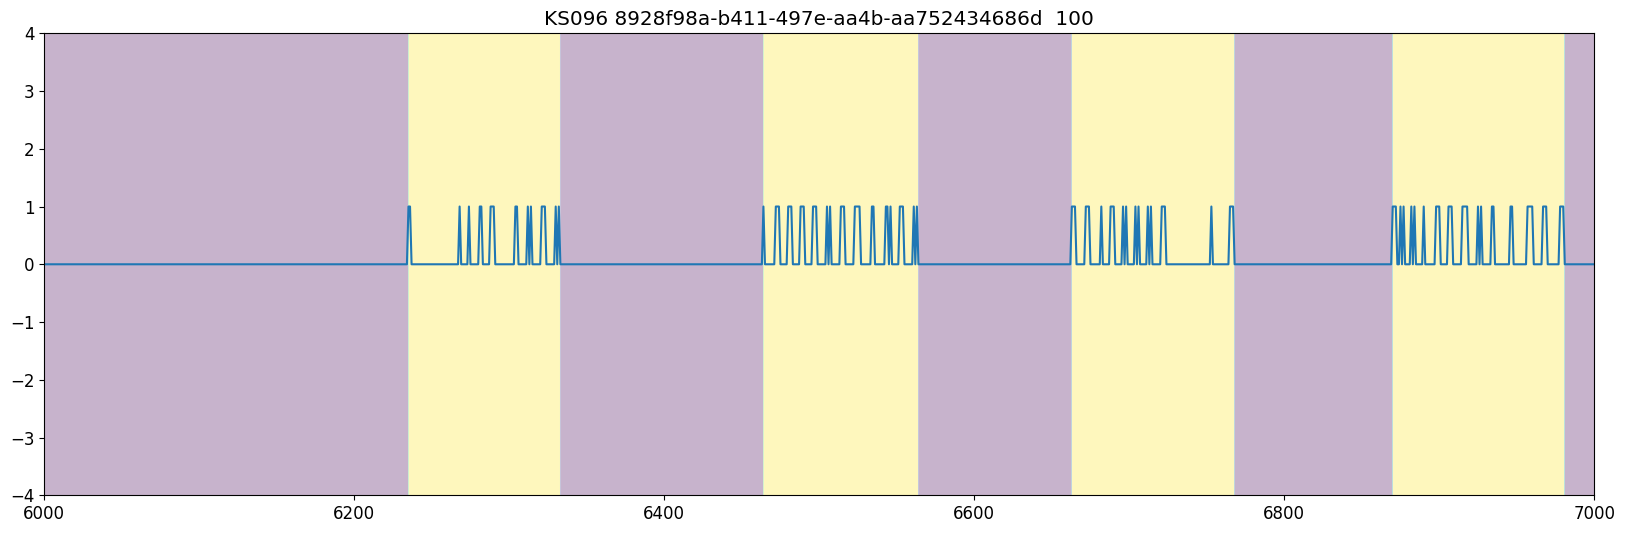

KS0968928f98a-b411-497e-aa4b-aa752434686d


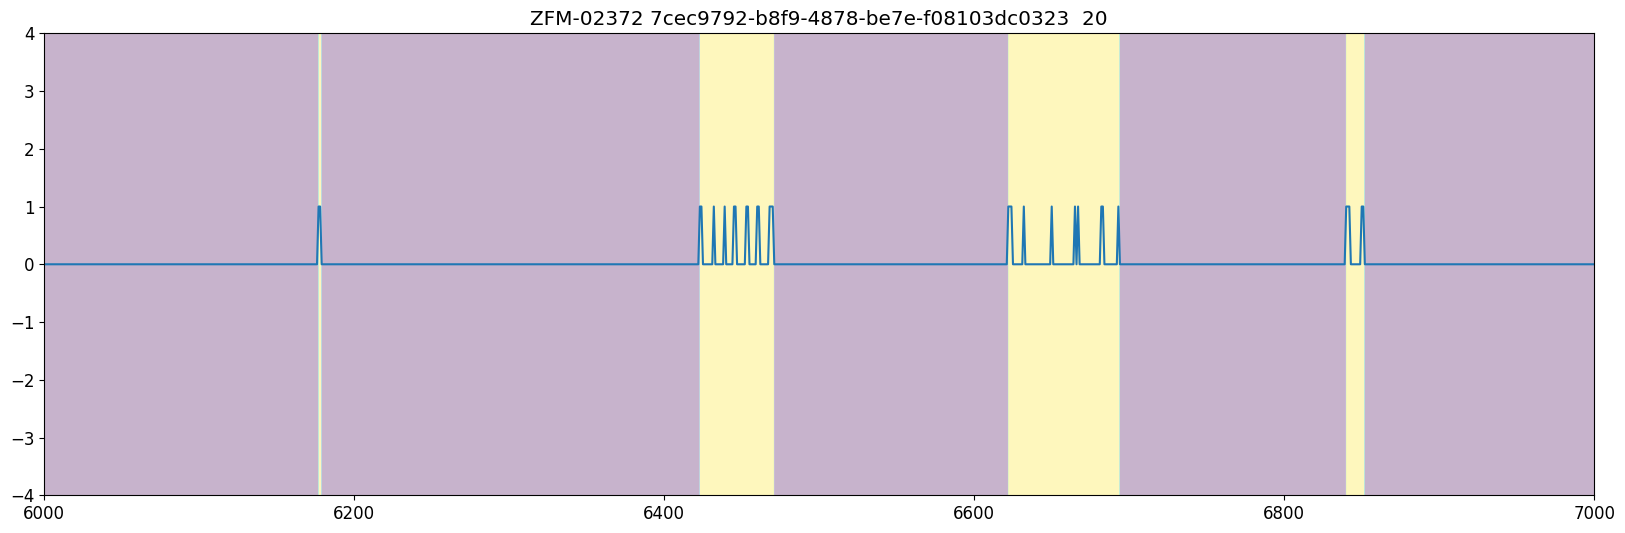

ZFM-023727cec9792-b8f9-4878-be7e-f08103dc0323


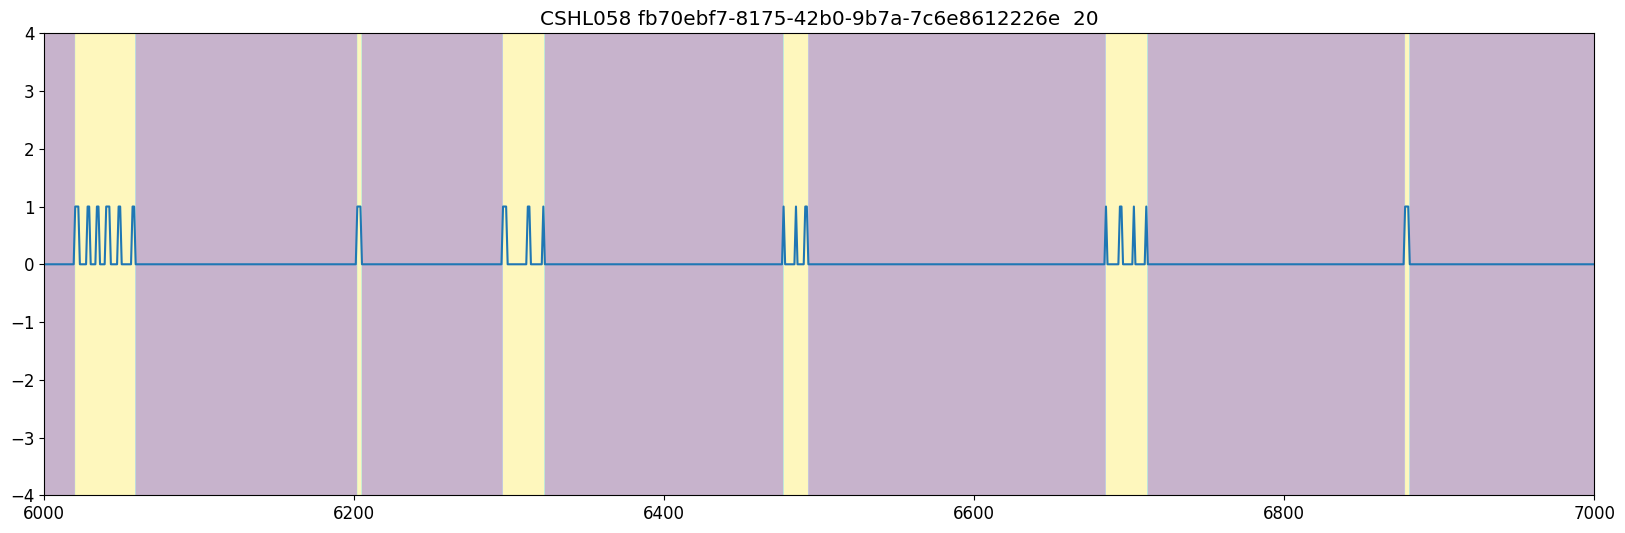

CSHL058fb70ebf7-8175-42b0-9b7a-7c6e8612226e


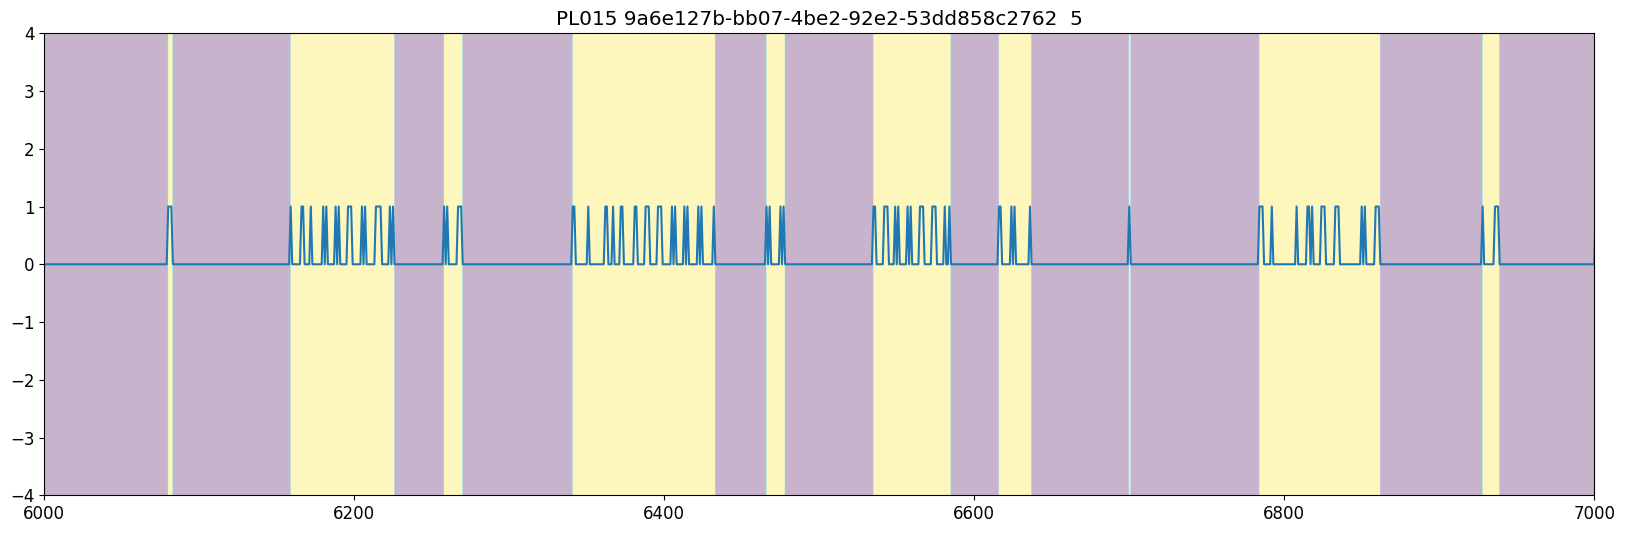

PL0159a6e127b-bb07-4be2-92e2-53dd858c2762


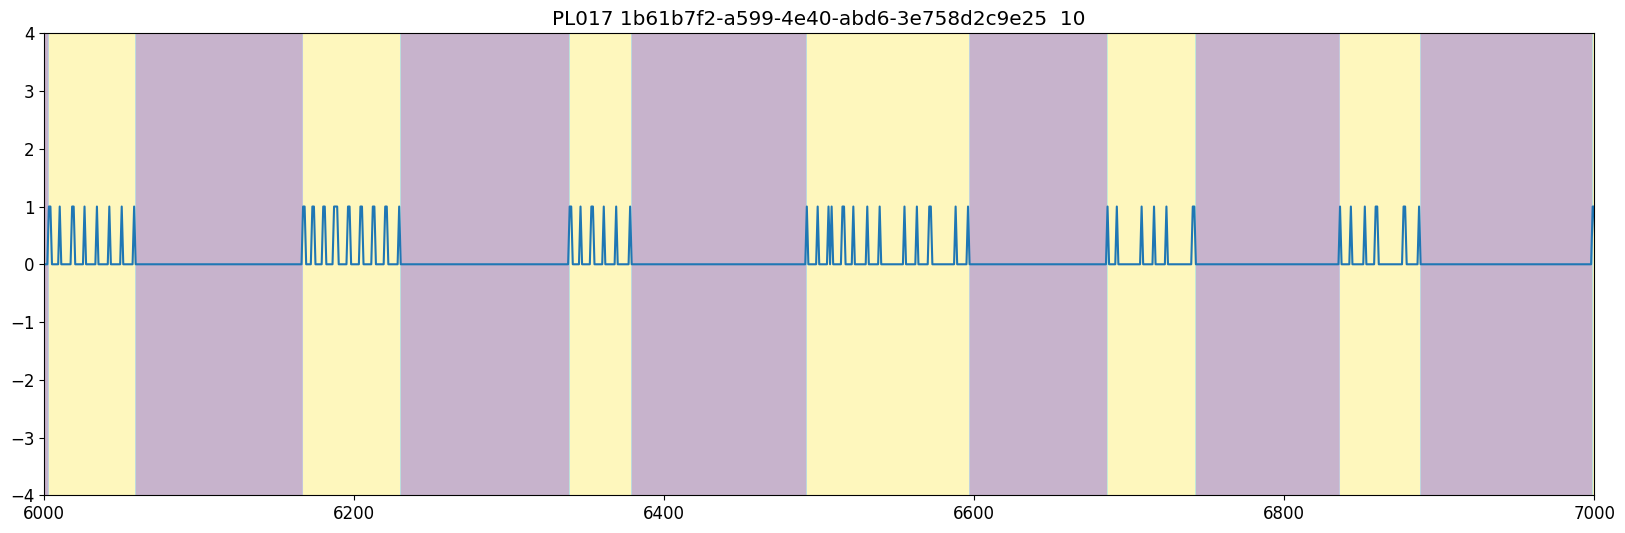

PL0171b61b7f2-a599-4e40-abd6-3e758d2c9e25


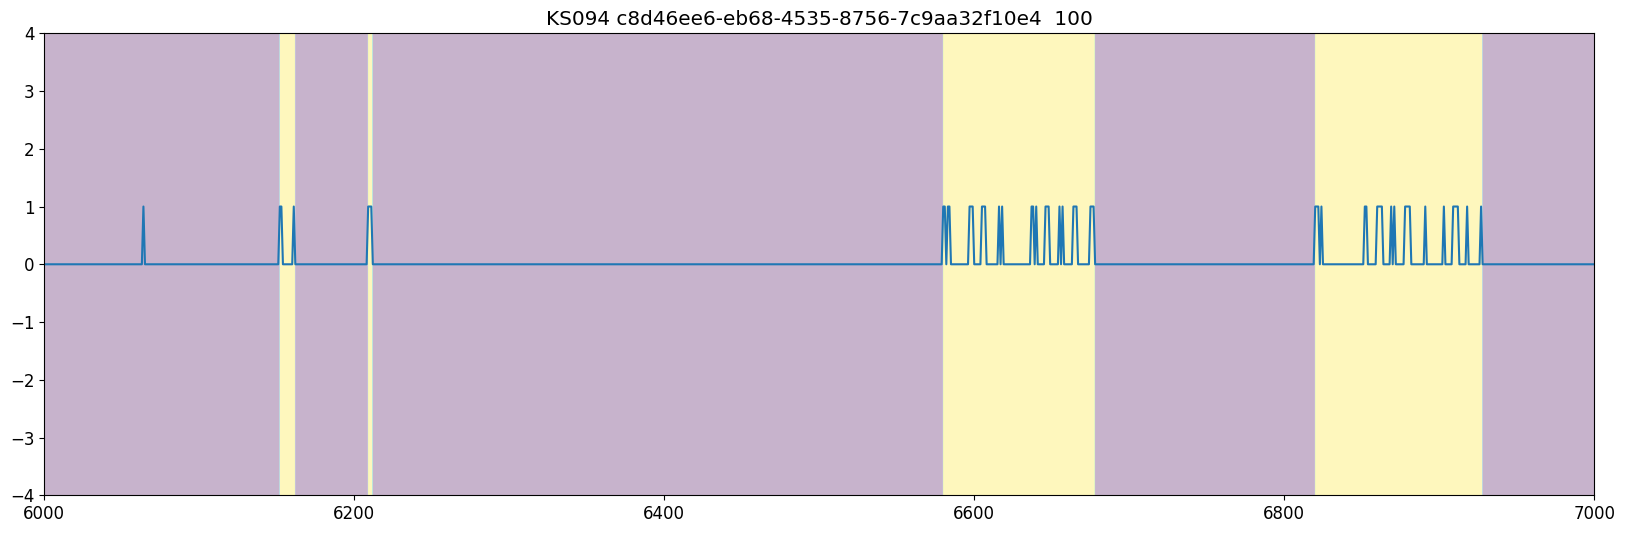

KS094c8d46ee6-eb68-4535-8756-7c9aa32f10e4


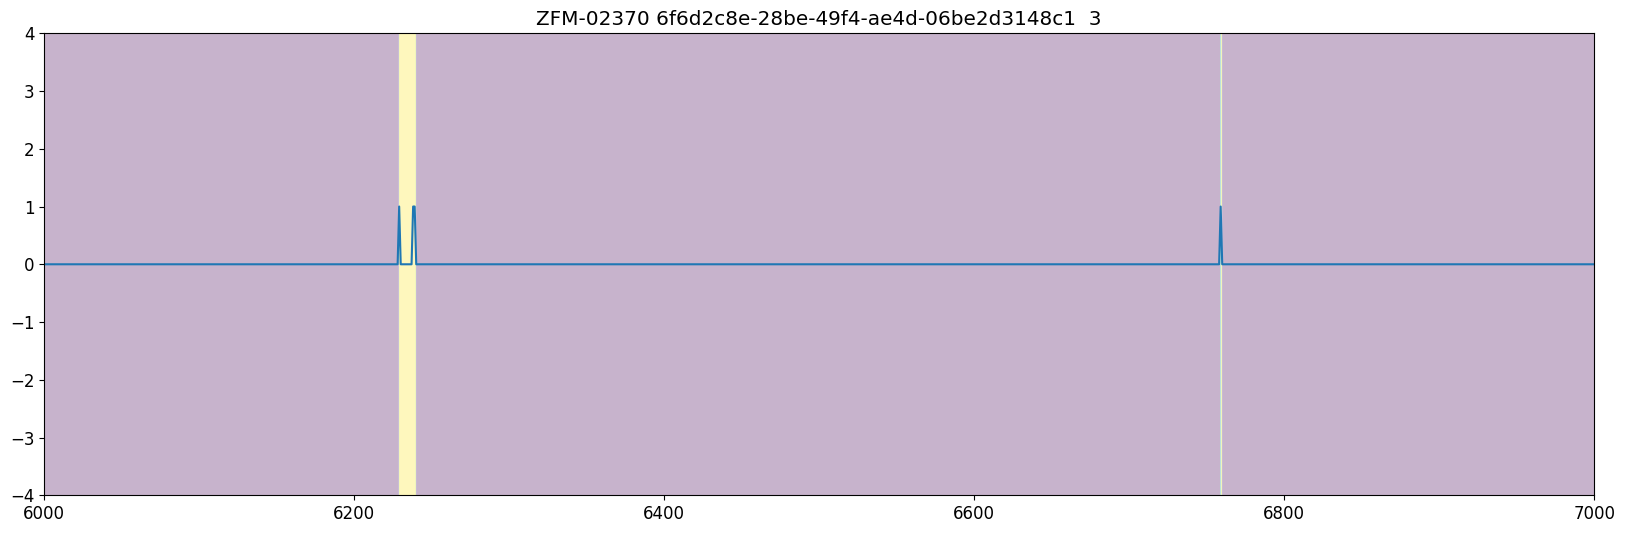

ZFM-023706f6d2c8e-28be-49f4-ae4d-06be2d3148c1


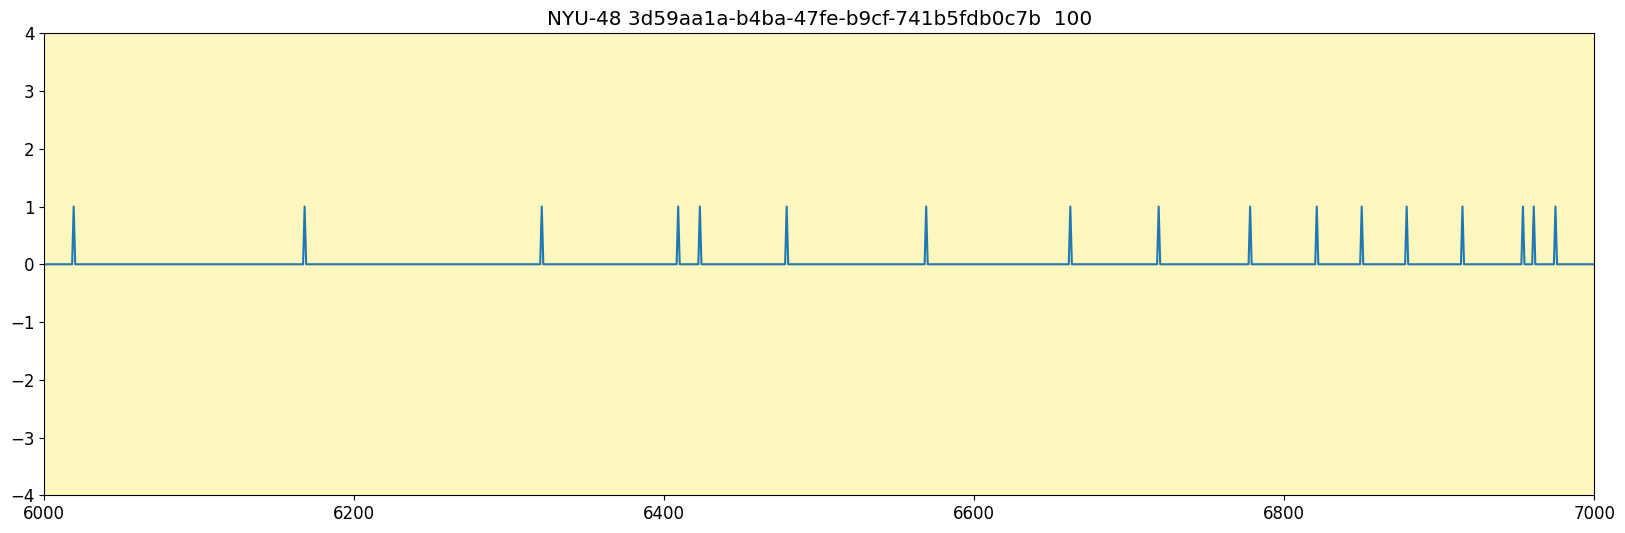

NYU-483d59aa1a-b4ba-47fe-b9cf-741b5fdb0c7b


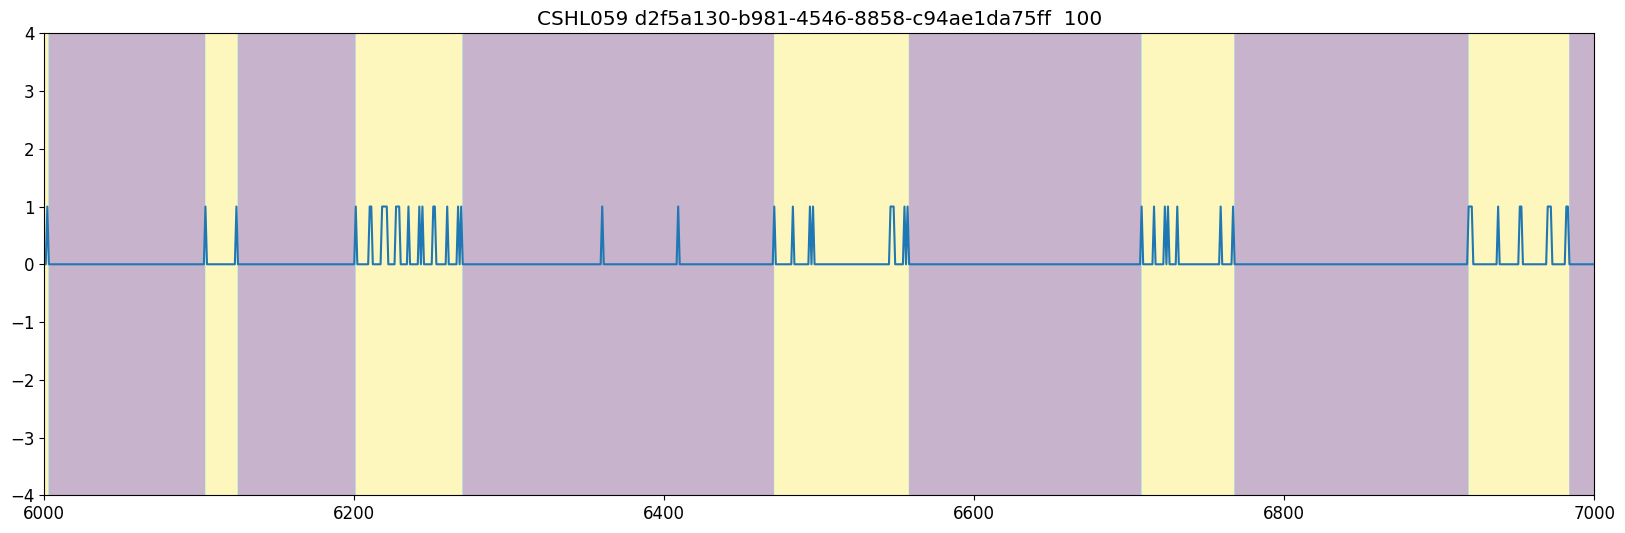

CSHL059d2f5a130-b981-4546-8858-c94ae1da75ff


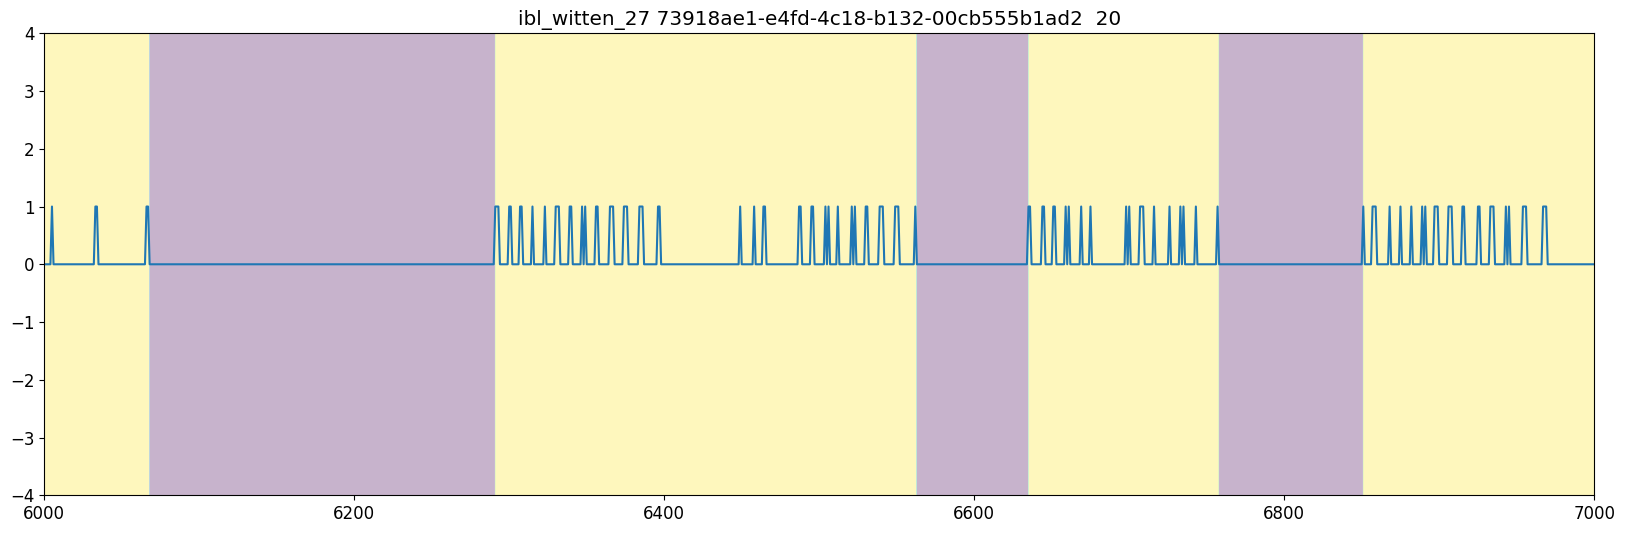

ibl_witten_2773918ae1-e4fd-4c18-b132-00cb555b1ad2


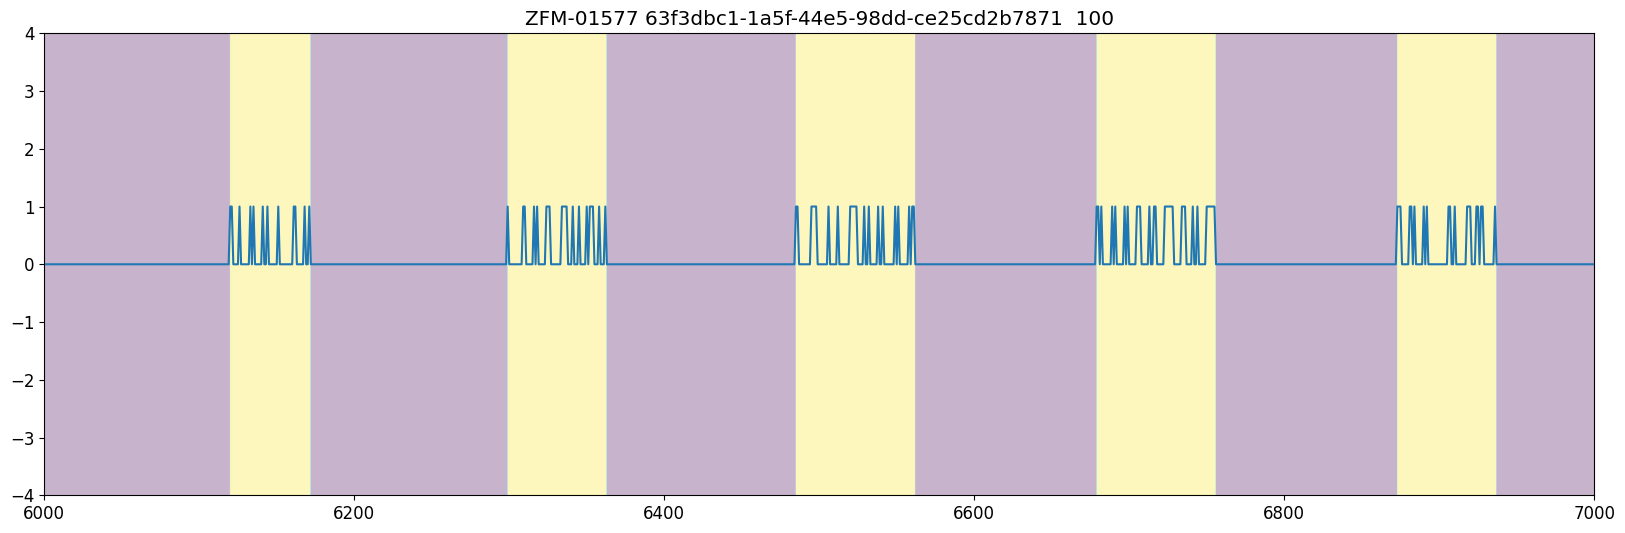

ZFM-0157763f3dbc1-1a5f-44e5-98dd-ce25cd2b7871


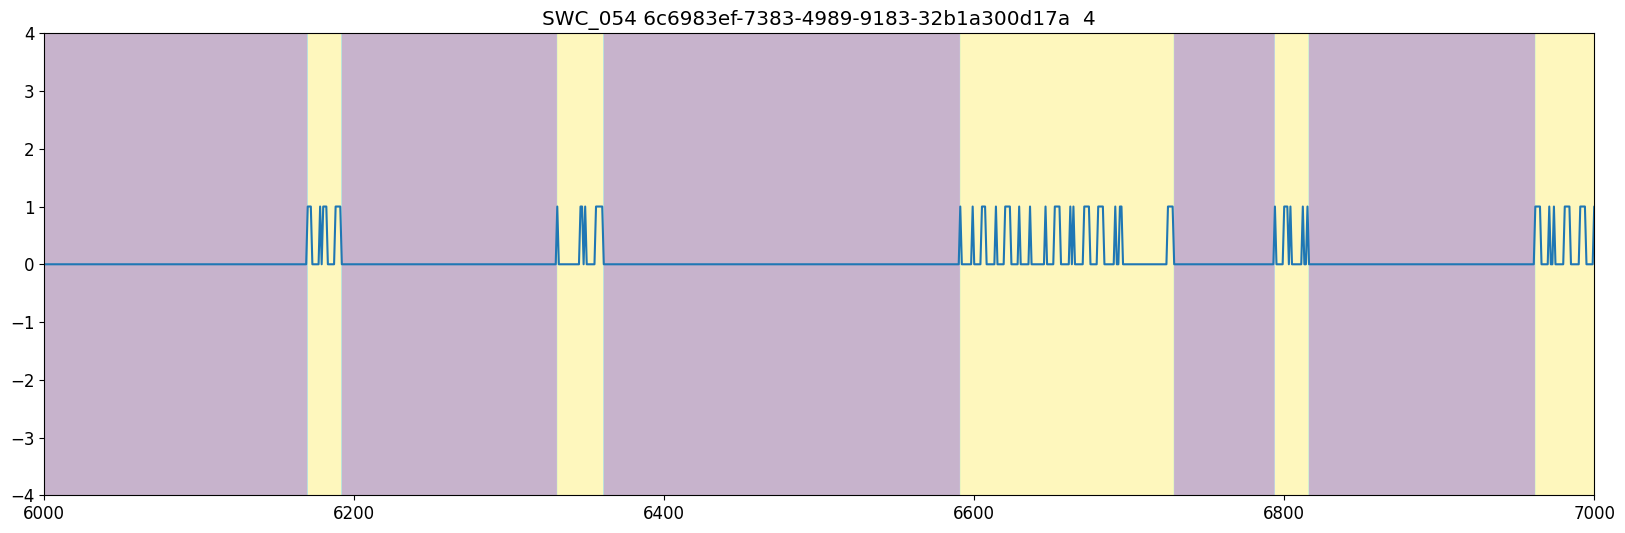

SWC_0546c6983ef-7383-4989-9183-32b1a300d17a


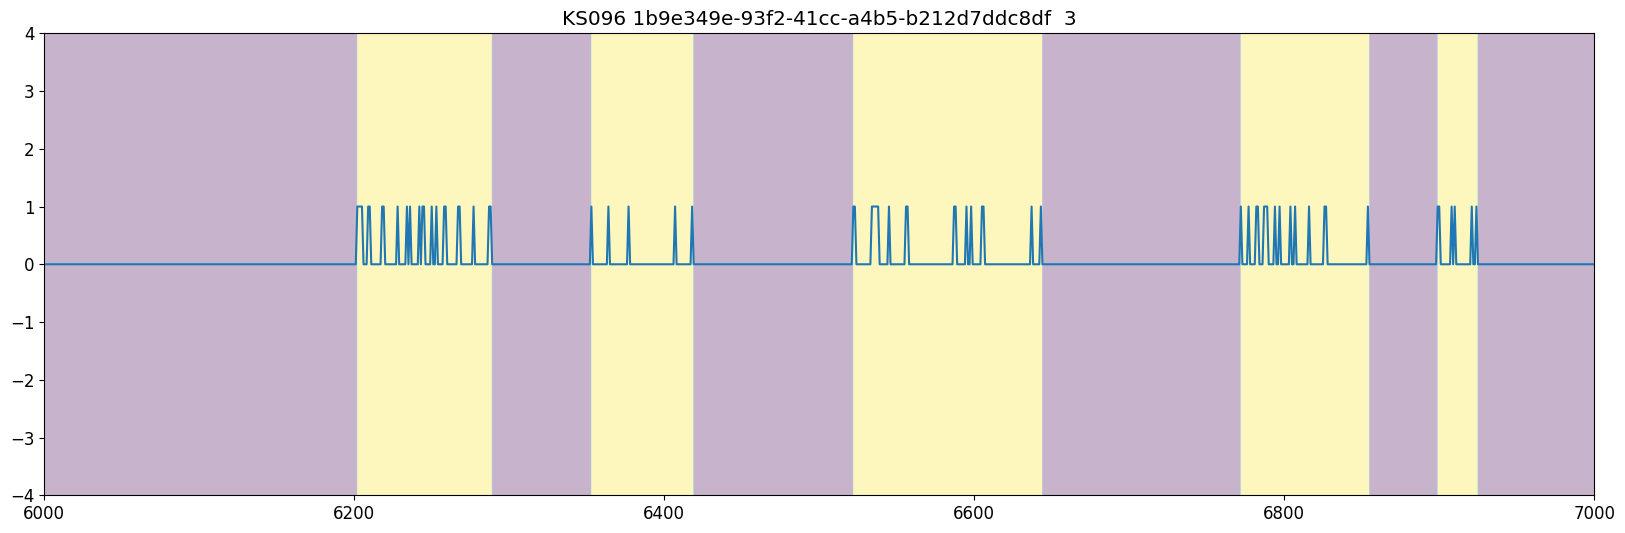

KS0961b9e349e-93f2-41cc-a4b5-b212d7ddc8df


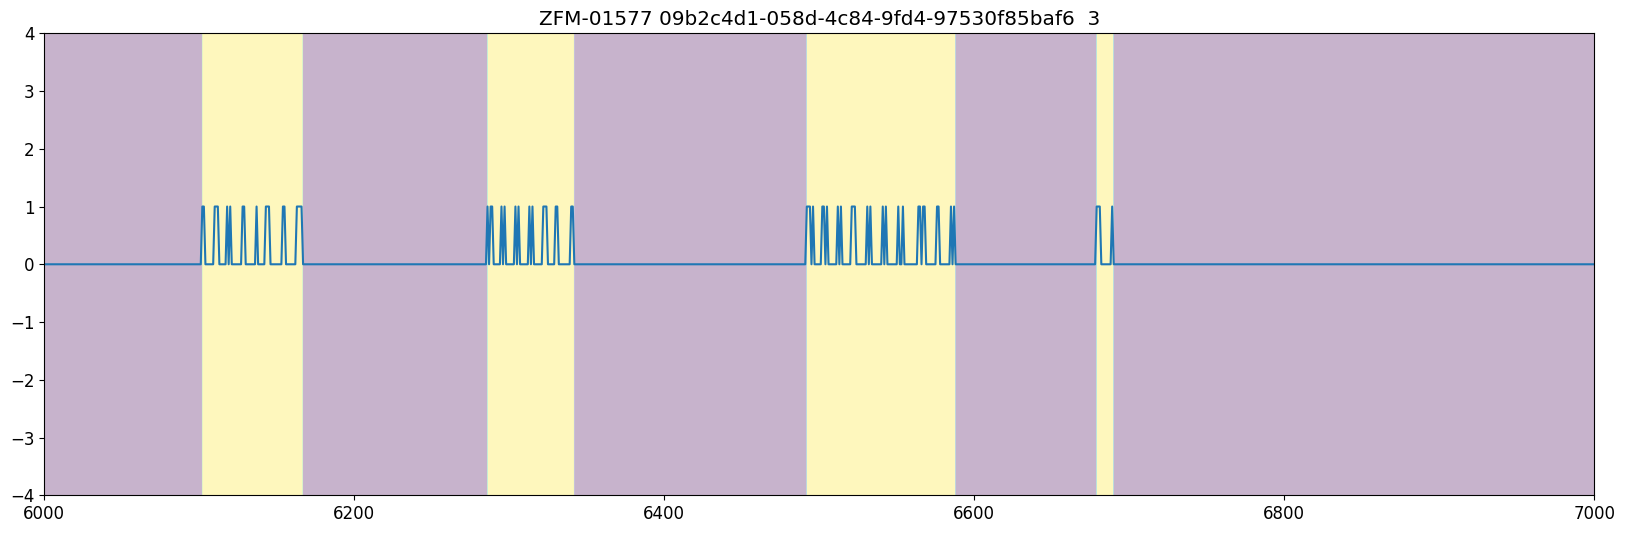

ZFM-0157709b2c4d1-058d-4c84-9fd4-97530f85baf6


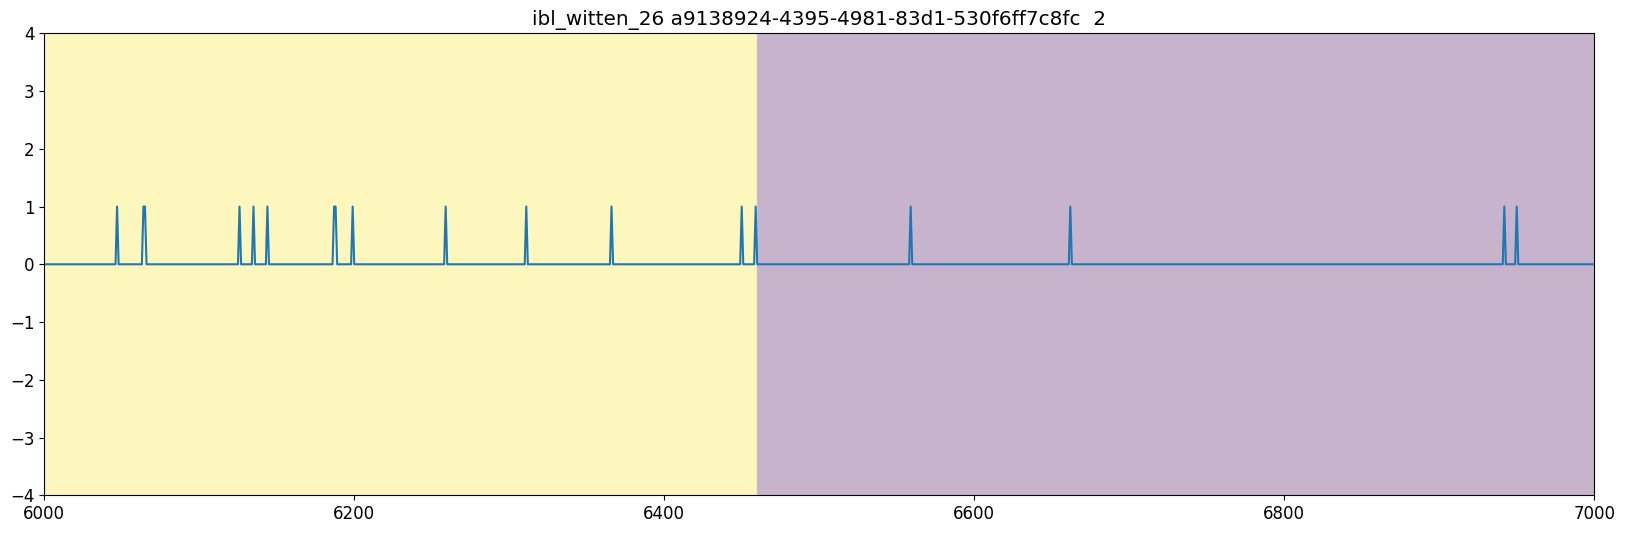

ibl_witten_26a9138924-4395-4981-83d1-530f6ff7c8fc


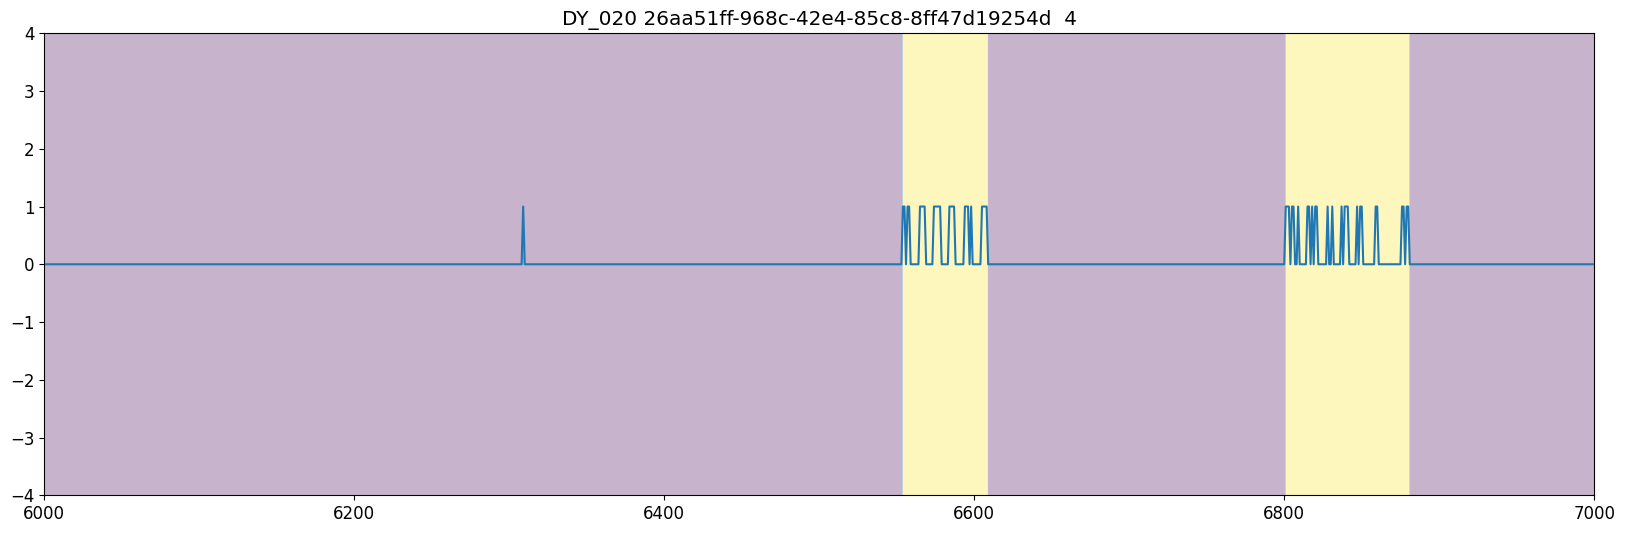

DY_02026aa51ff-968c-42e4-85c8-8ff47d19254d


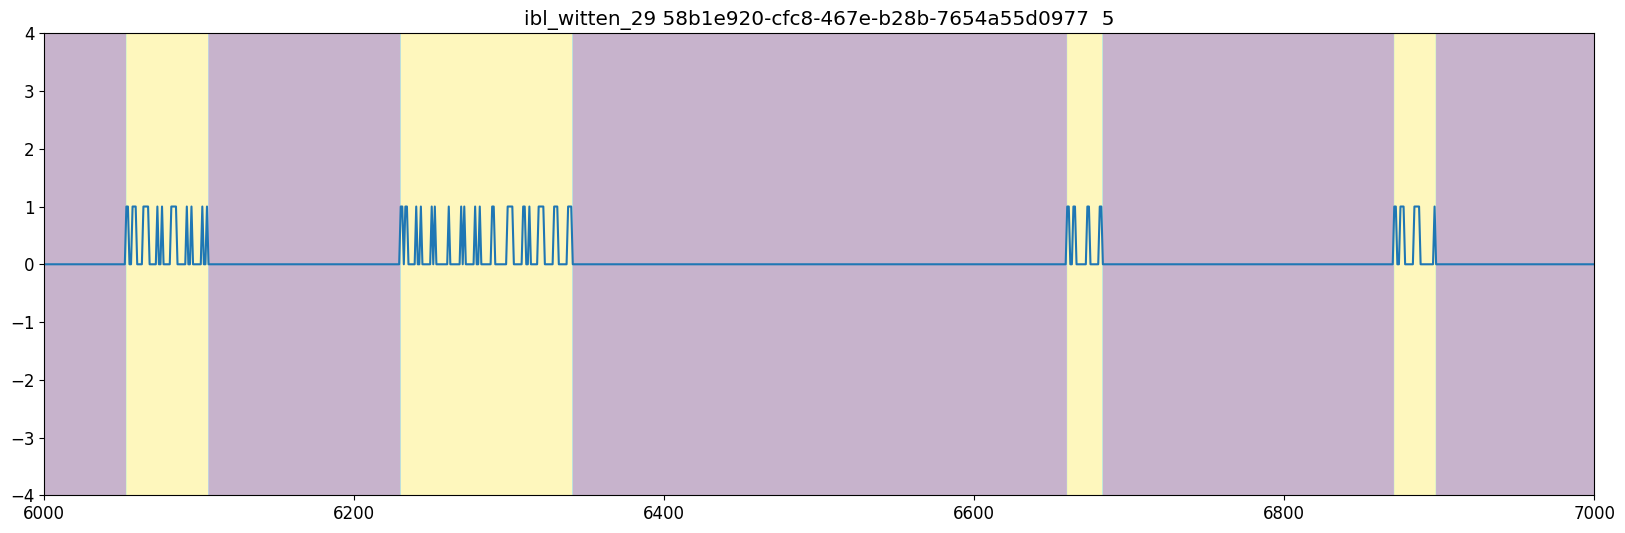

ibl_witten_2958b1e920-cfc8-467e-b28b-7654a55d0977


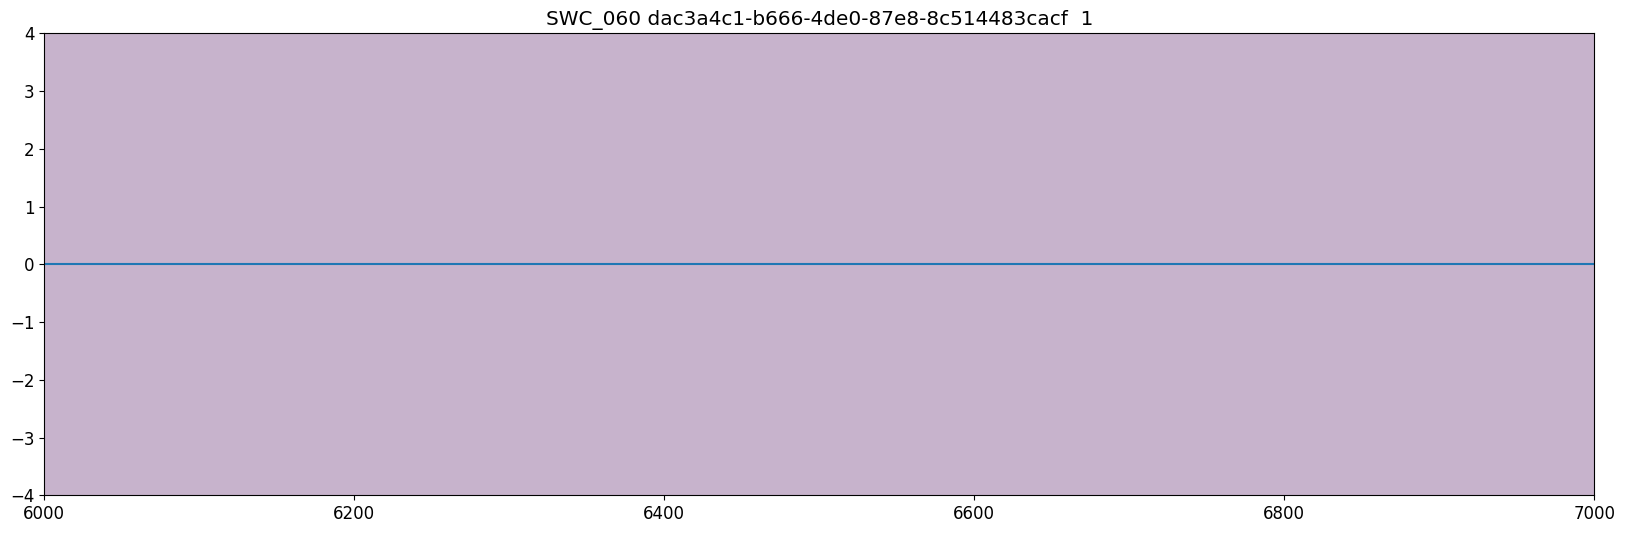

SWC_060dac3a4c1-b666-4de0-87e8-8c514483cacf


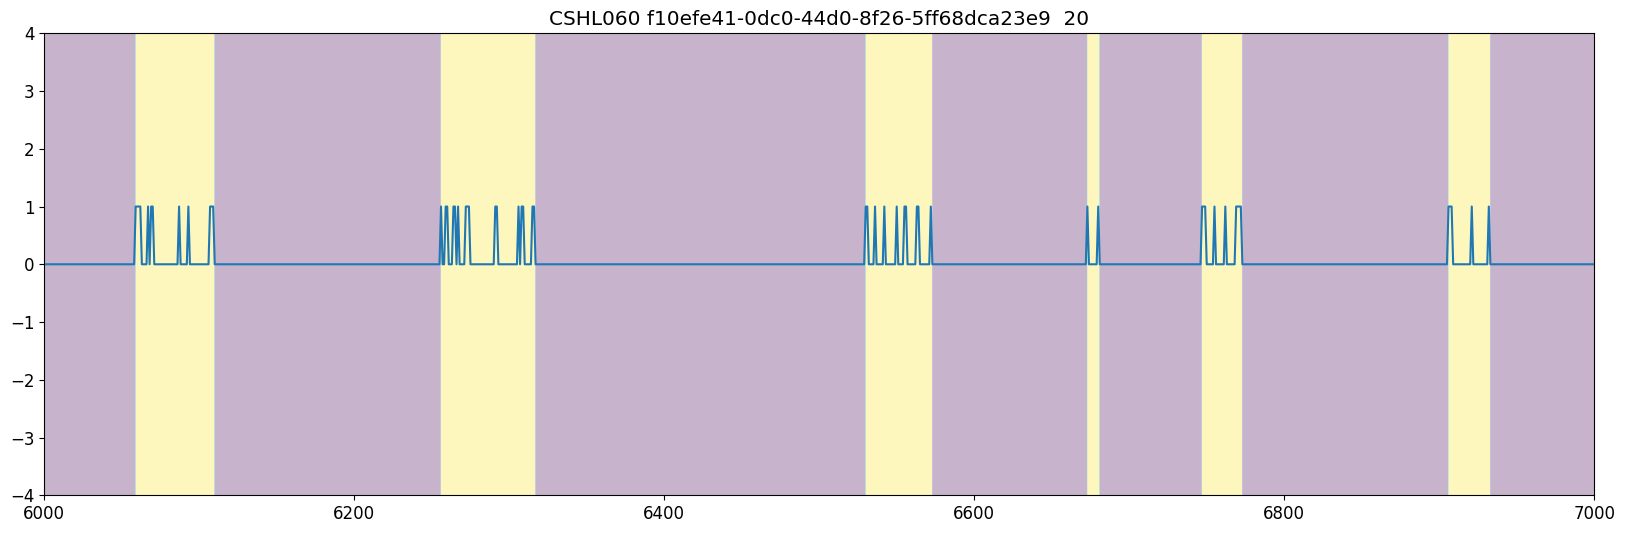

CSHL060f10efe41-0dc0-44d0-8f26-5ff68dca23e9


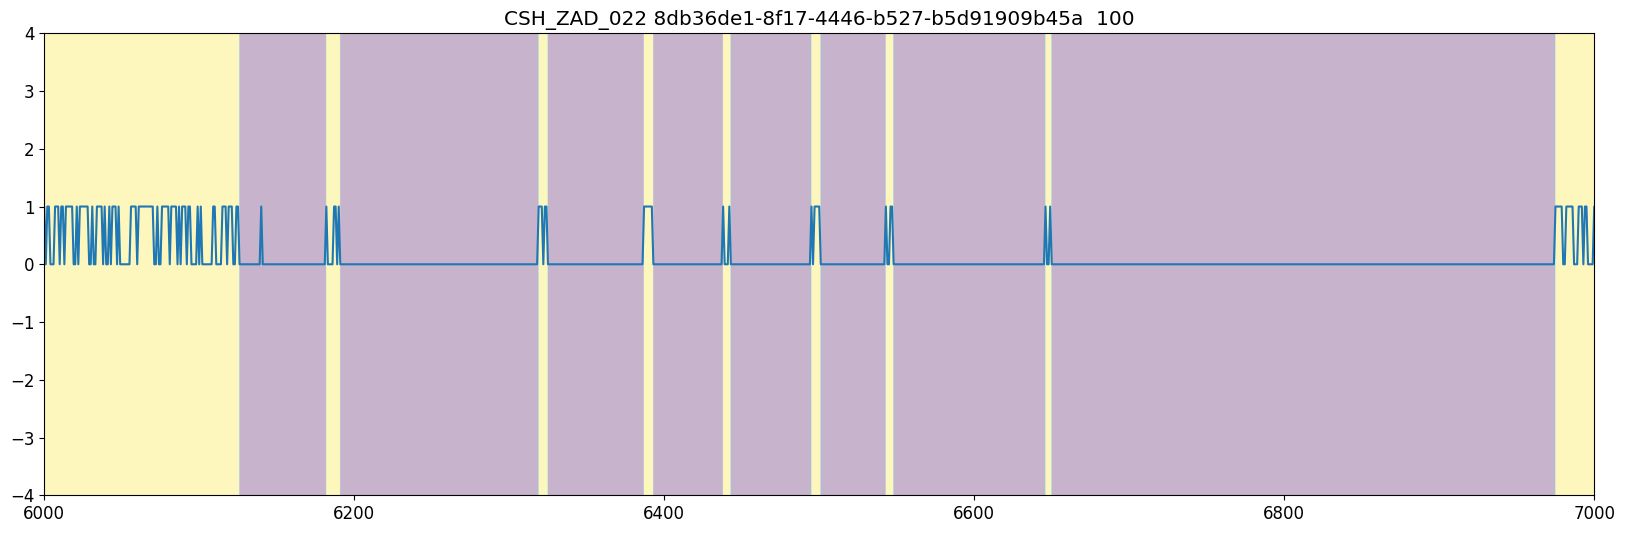

CSH_ZAD_0228db36de1-8f17-4446-b527-b5d91909b45a


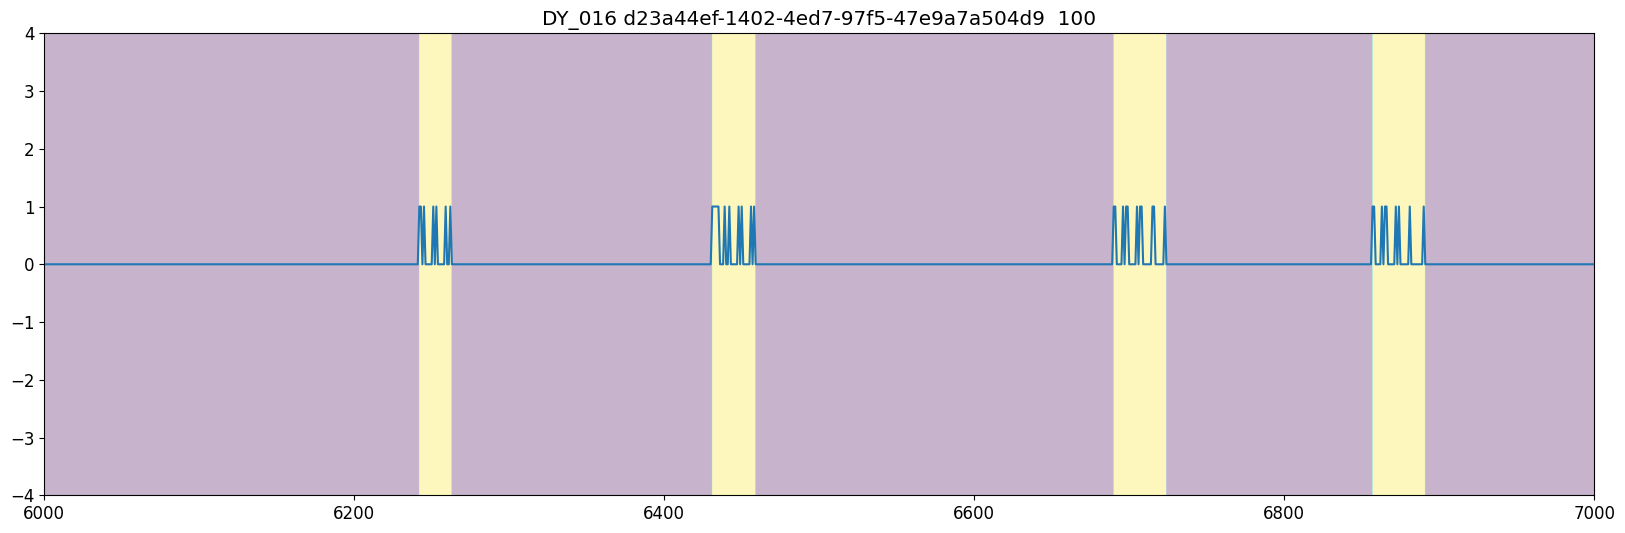

DY_016d23a44ef-1402-4ed7-97f5-47e9a7a504d9


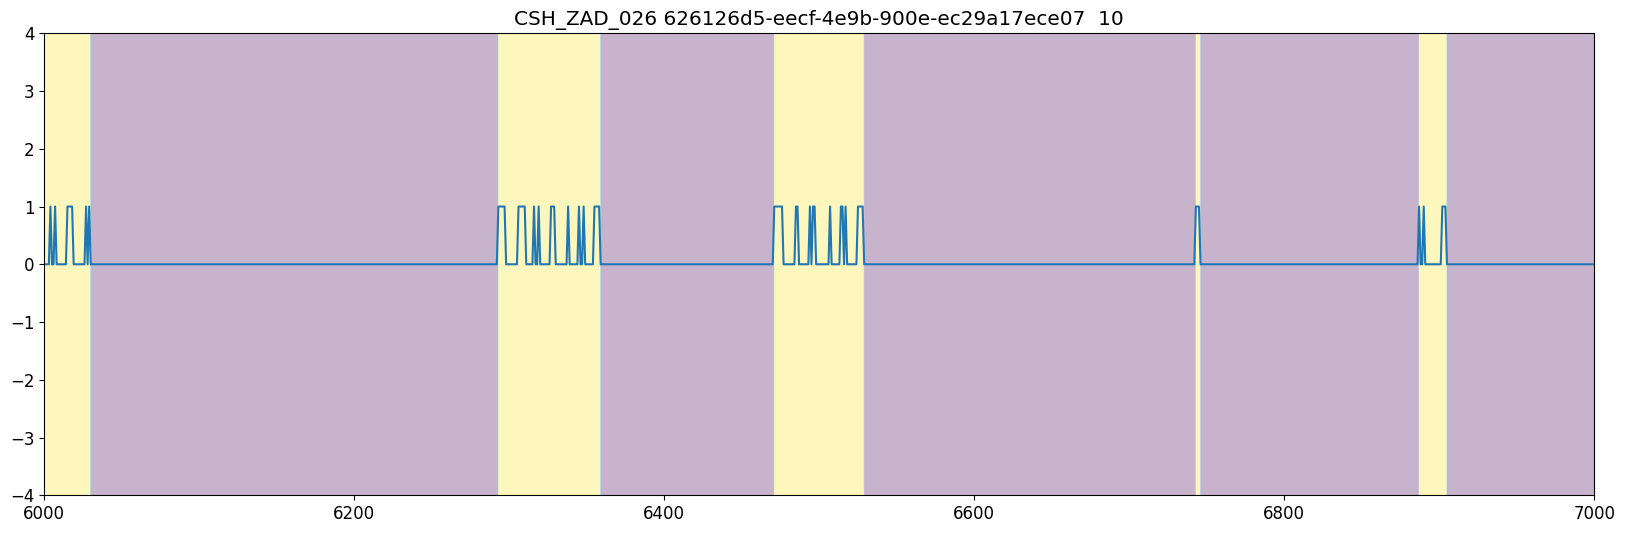

CSH_ZAD_026626126d5-eecf-4e9b-900e-ec29a17ece07


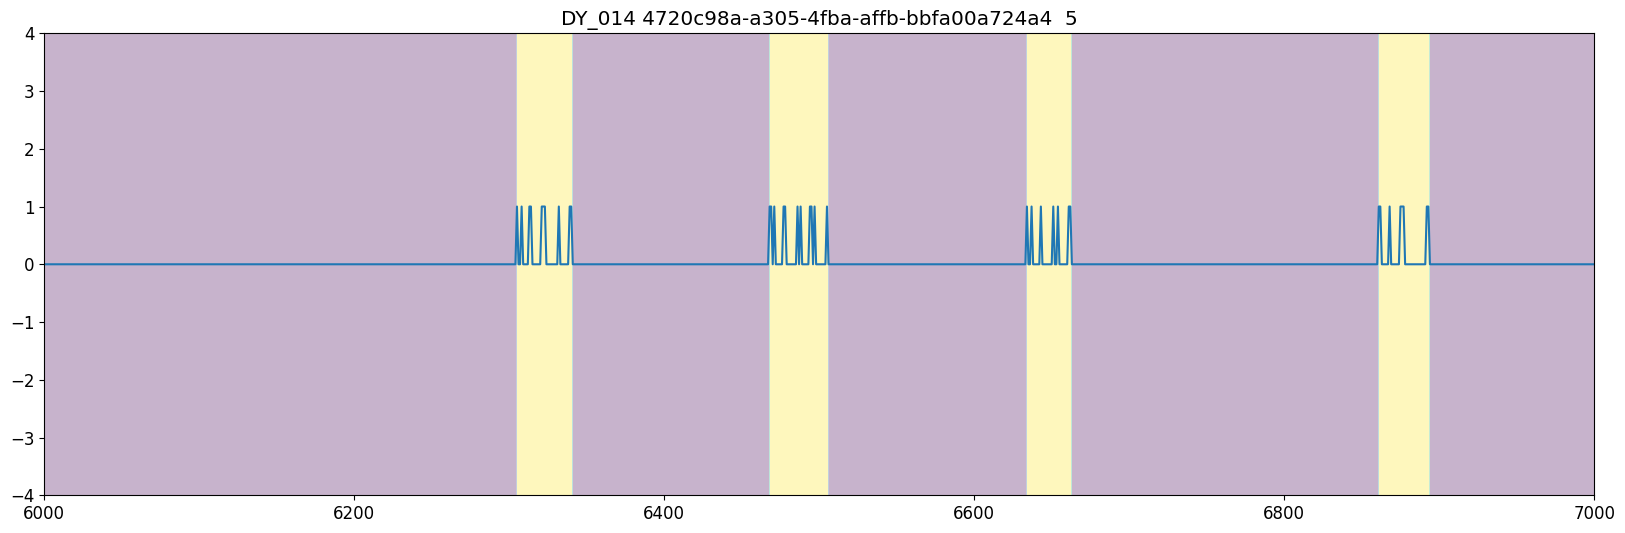

DY_0144720c98a-a305-4fba-affb-bbfa00a724a4


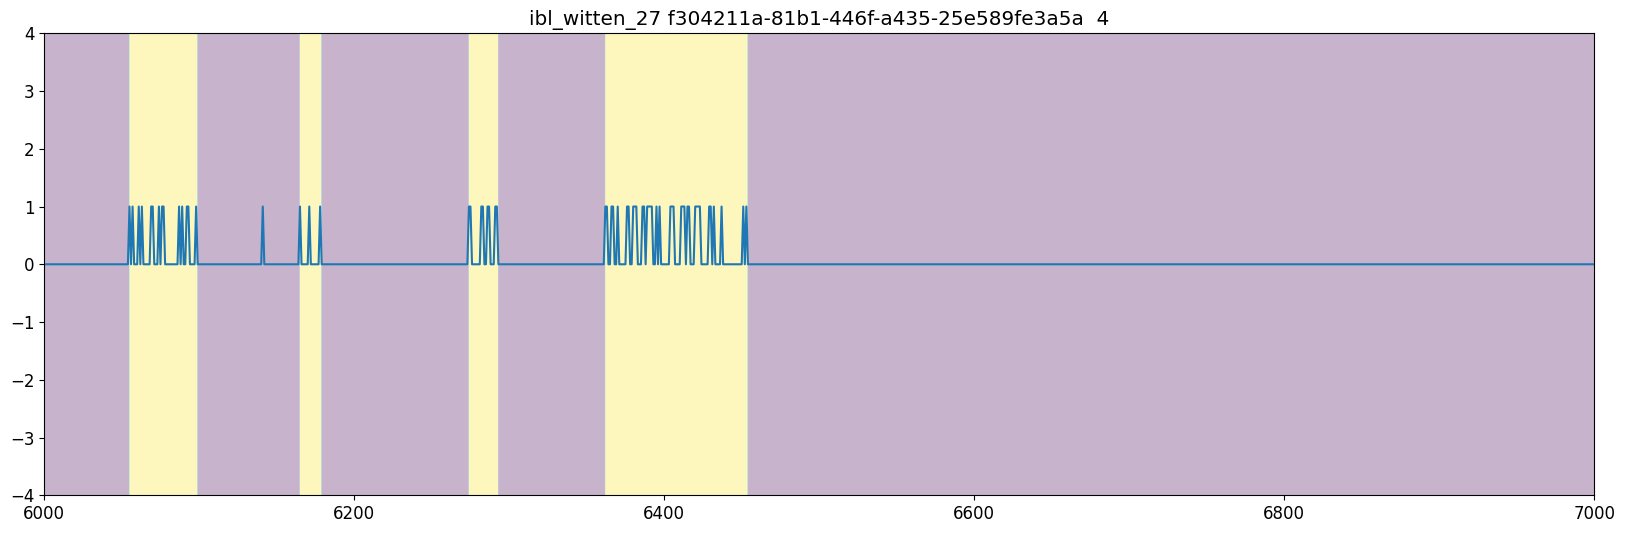

ibl_witten_27f304211a-81b1-446f-a435-25e589fe3a5a


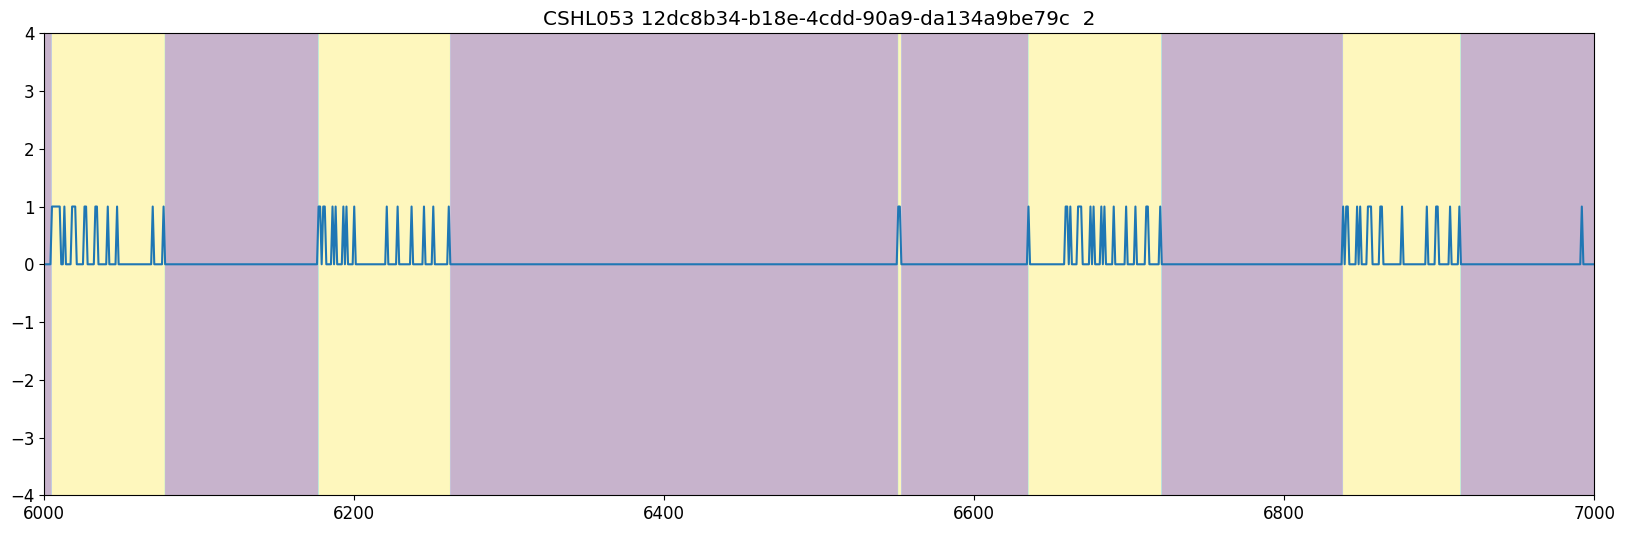

CSHL05312dc8b34-b18e-4cdd-90a9-da134a9be79c


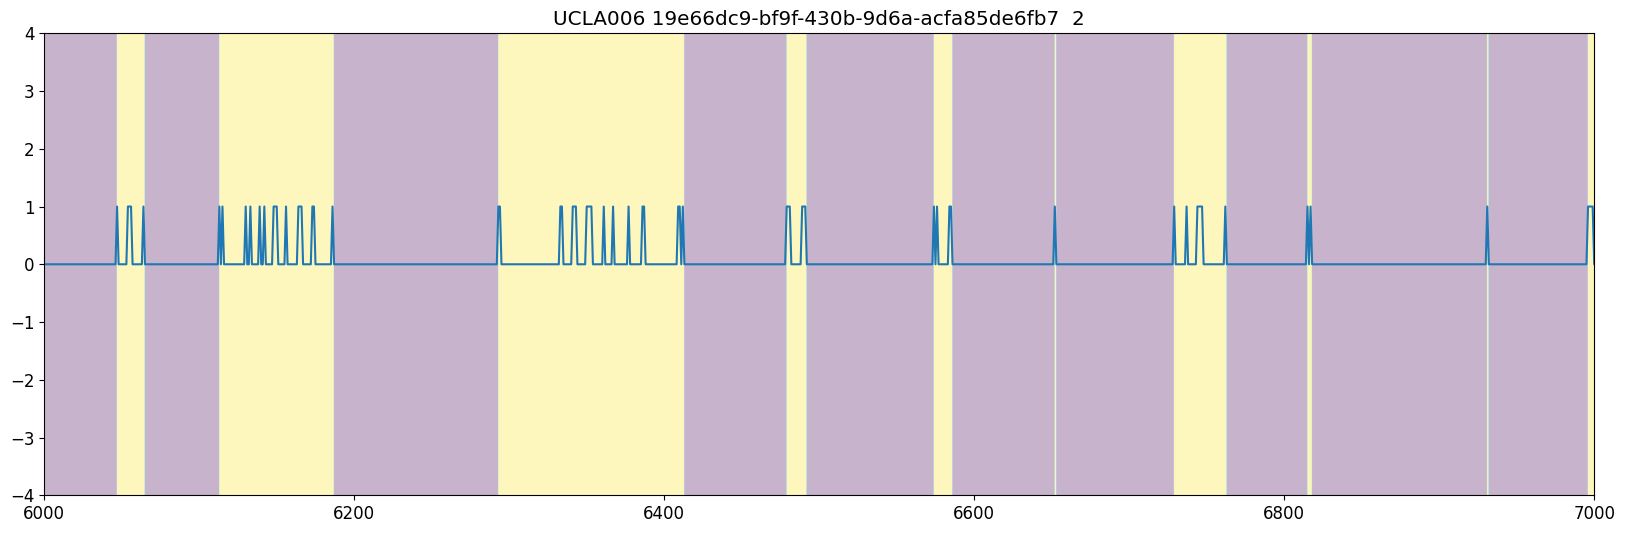

UCLA00619e66dc9-bf9f-430b-9d6a-acfa85de6fb7


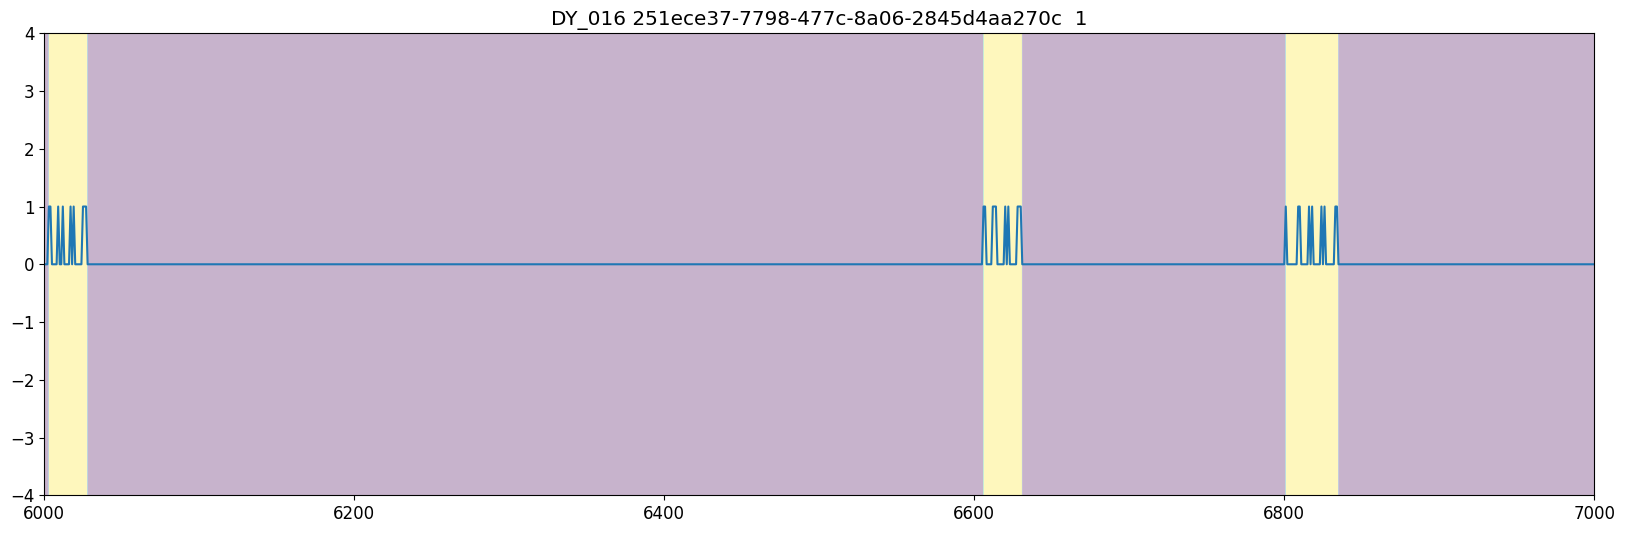

DY_016251ece37-7798-477c-8a06-2845d4aa270c


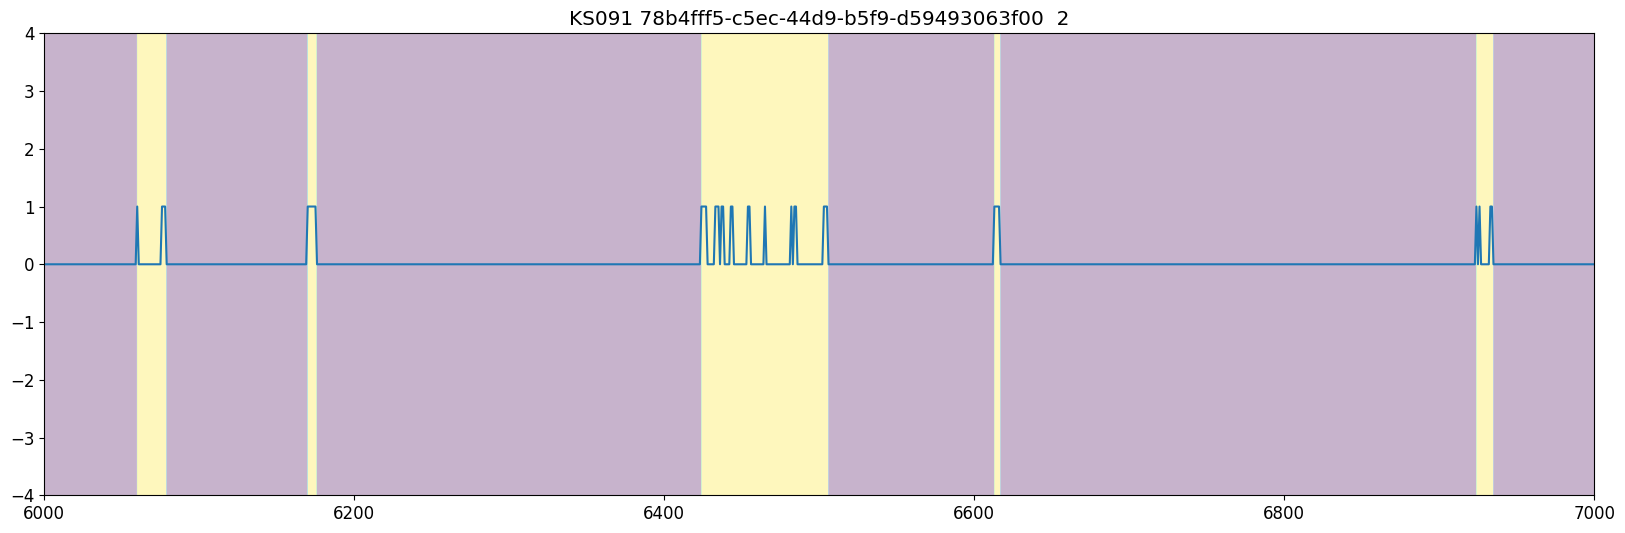

KS09178b4fff5-c5ec-44d9-b5f9-d59493063f00


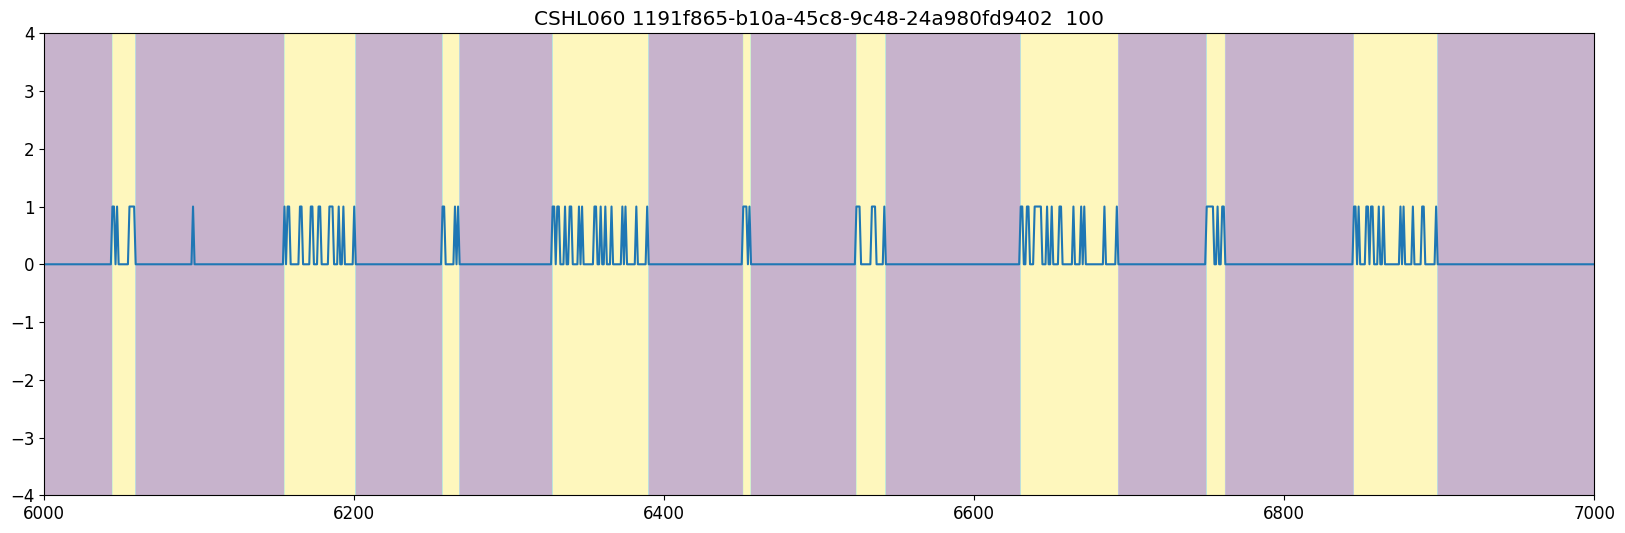

CSHL0601191f865-b10a-45c8-9c48-24a980fd9402


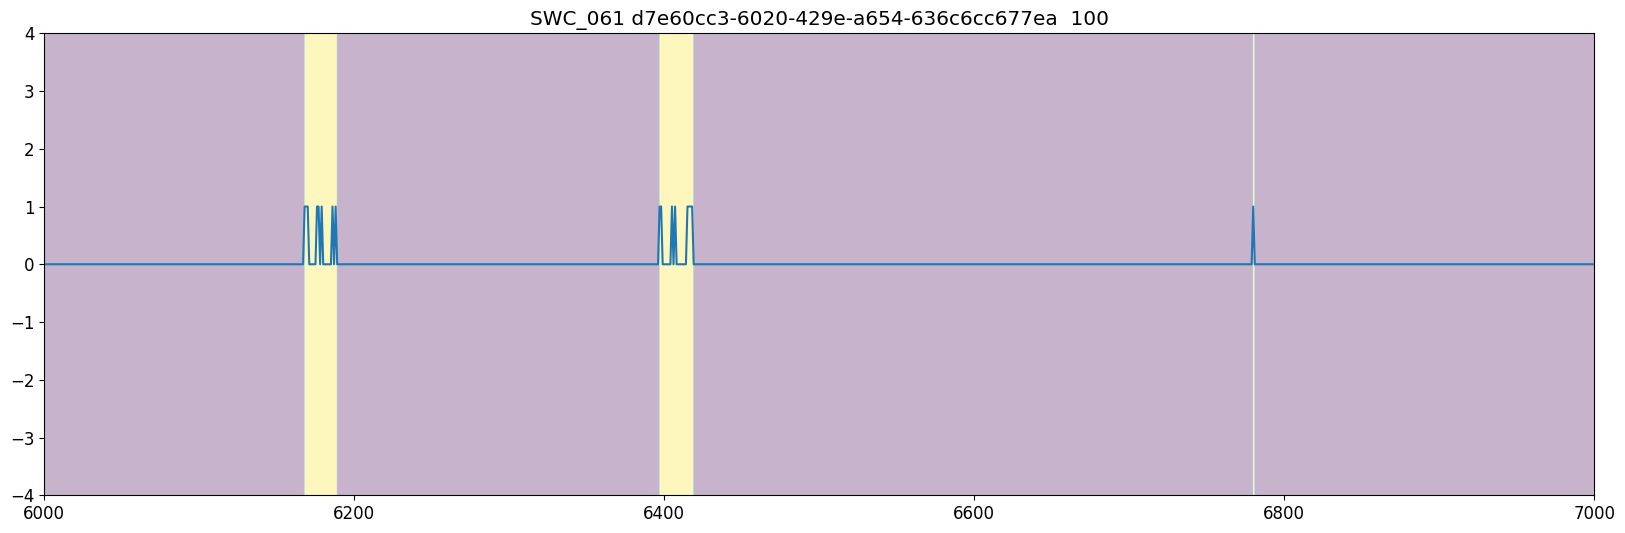

SWC_061d7e60cc3-6020-429e-a654-636c6cc677ea


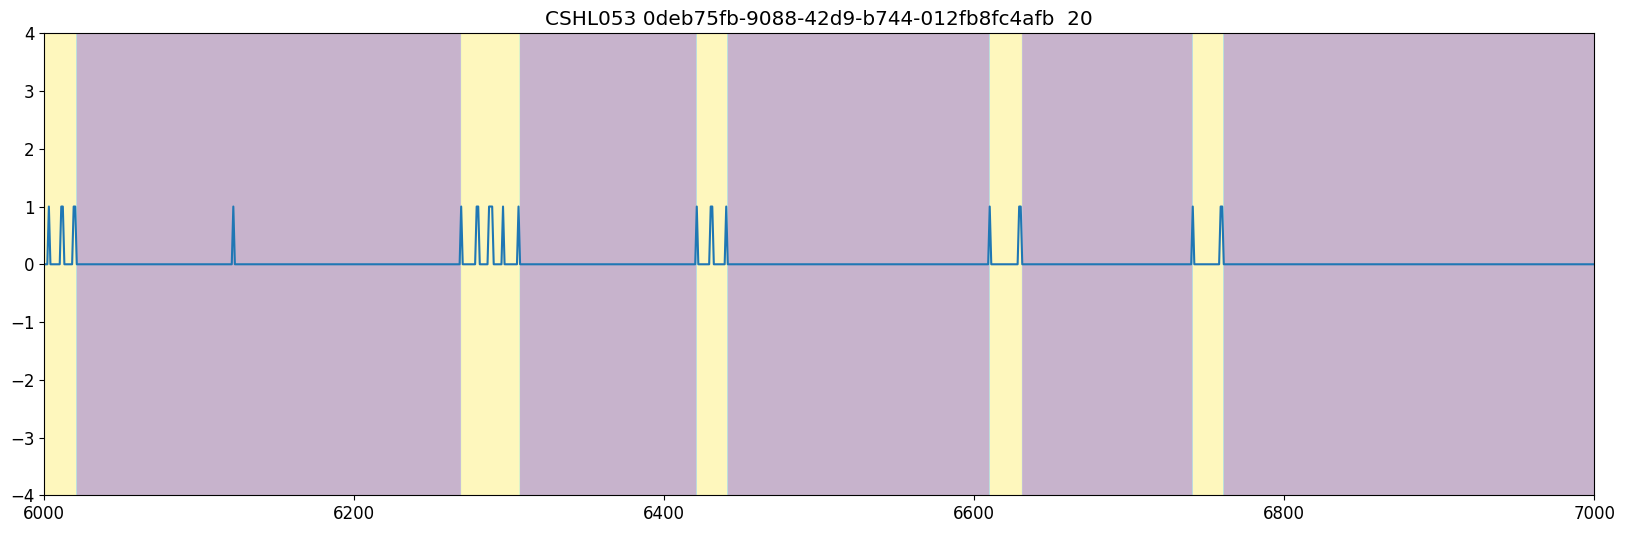

CSHL0530deb75fb-9088-42d9-b744-012fb8fc4afb


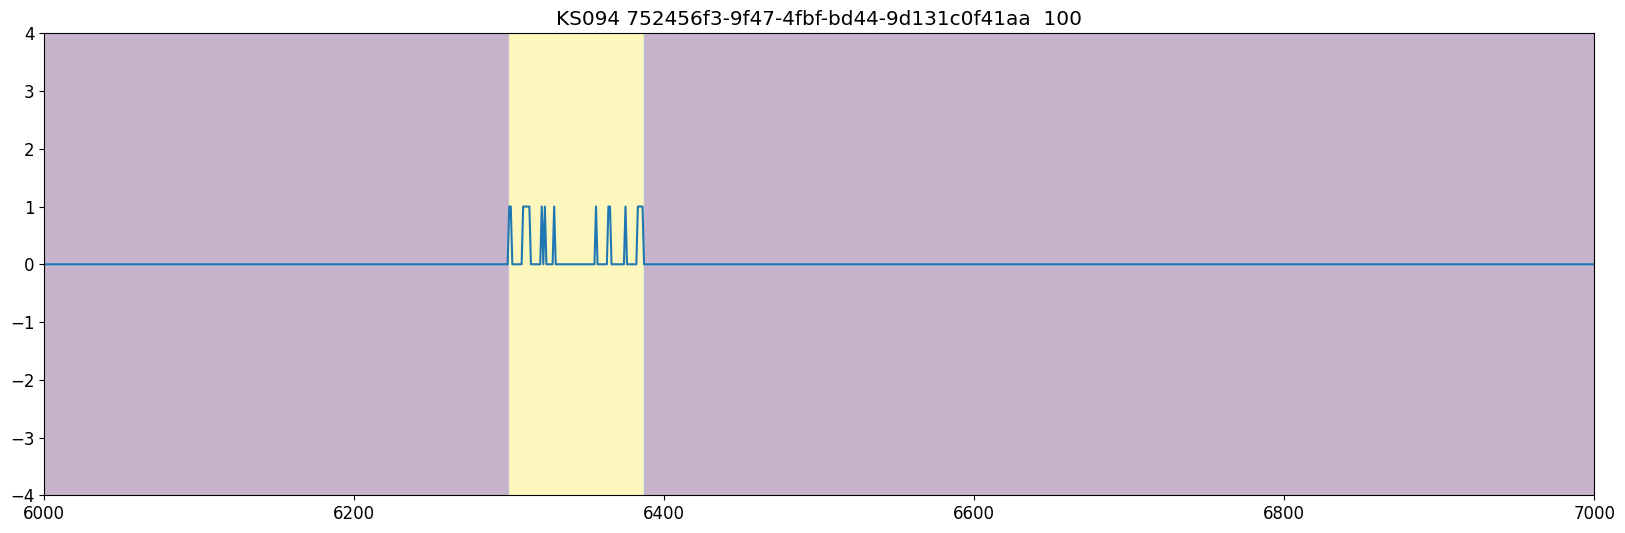

KS094752456f3-9f47-4fbf-bd44-9d131c0f41aa


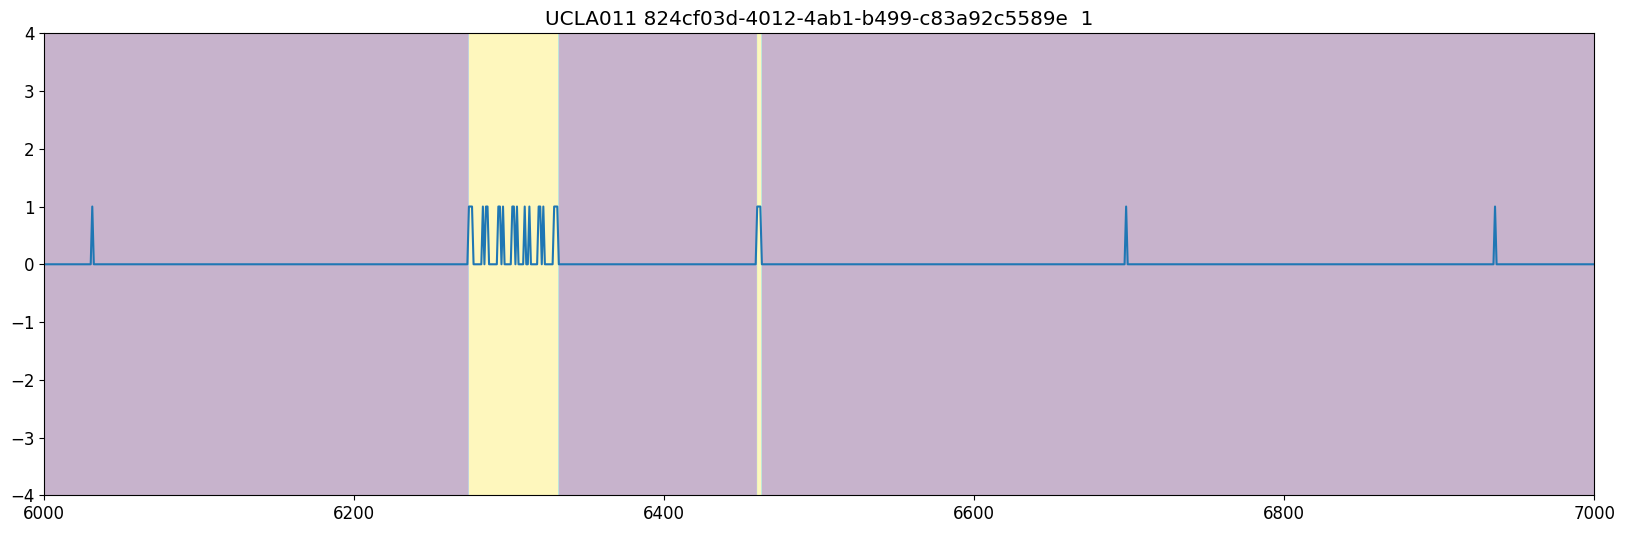

UCLA011824cf03d-4012-4ab1-b499-c83a92c5589e


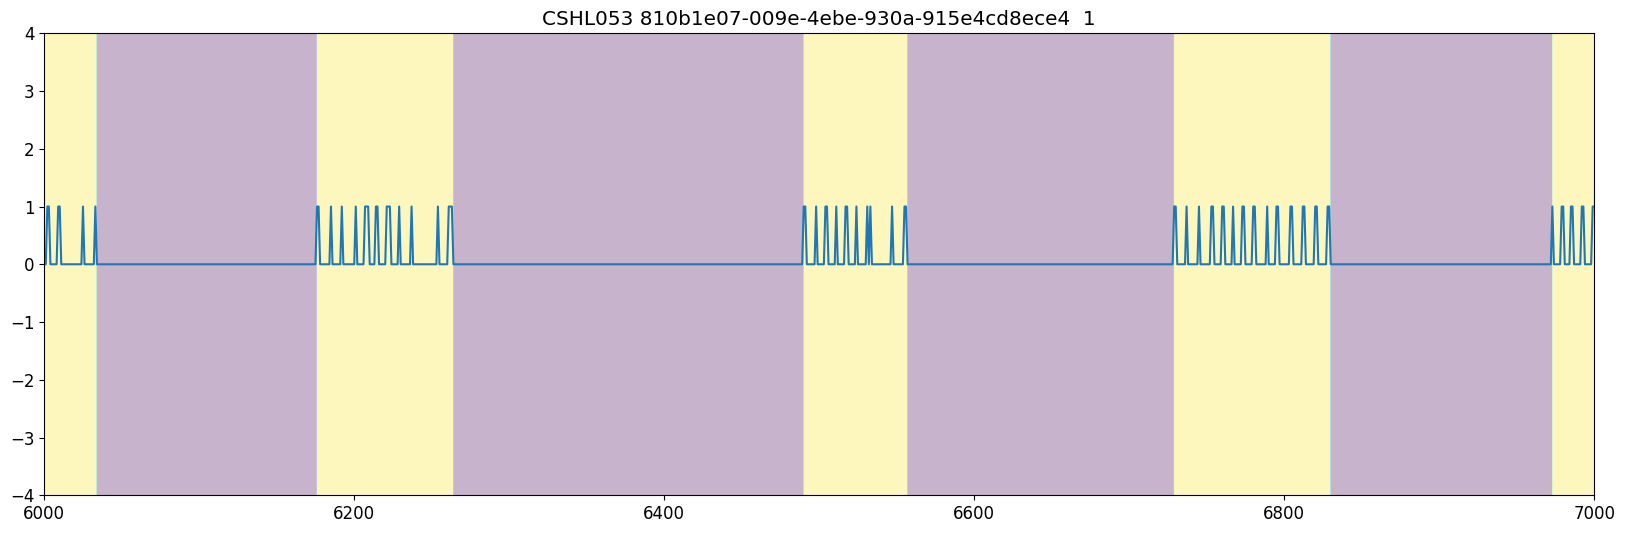

CSHL053810b1e07-009e-4ebe-930a-915e4cd8ece4


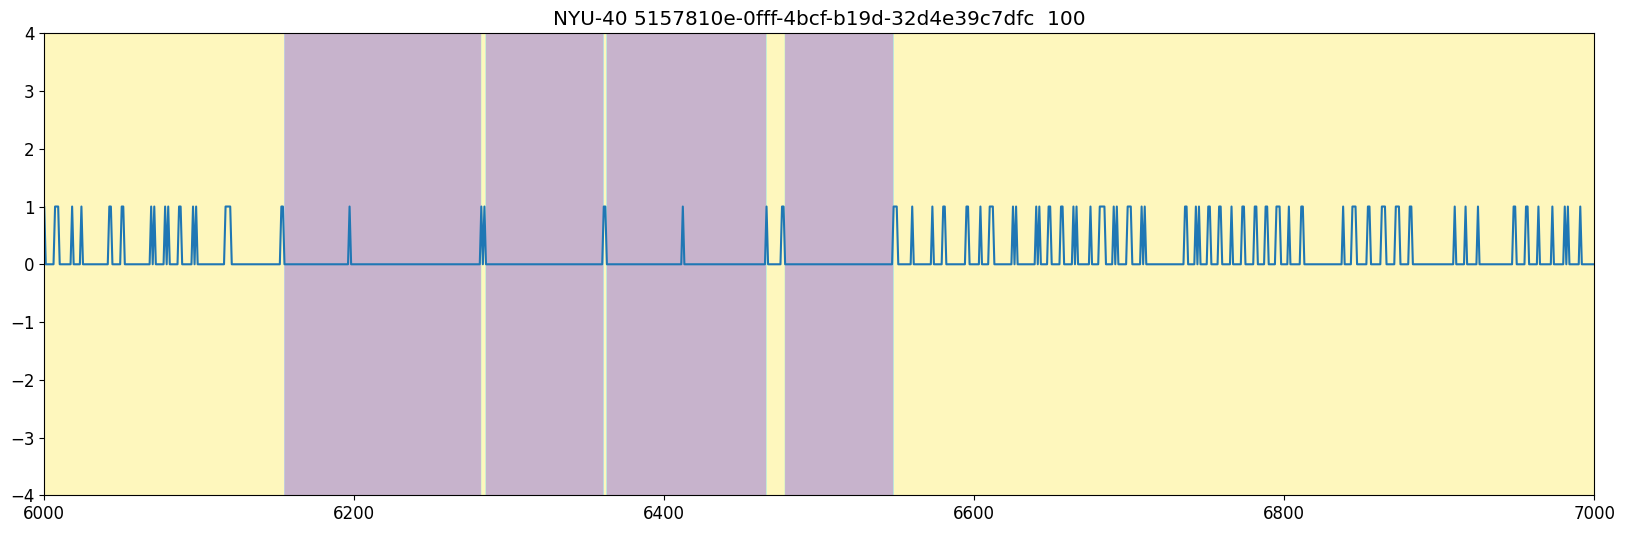

NYU-405157810e-0fff-4bcf-b19d-32d4e39c7dfc


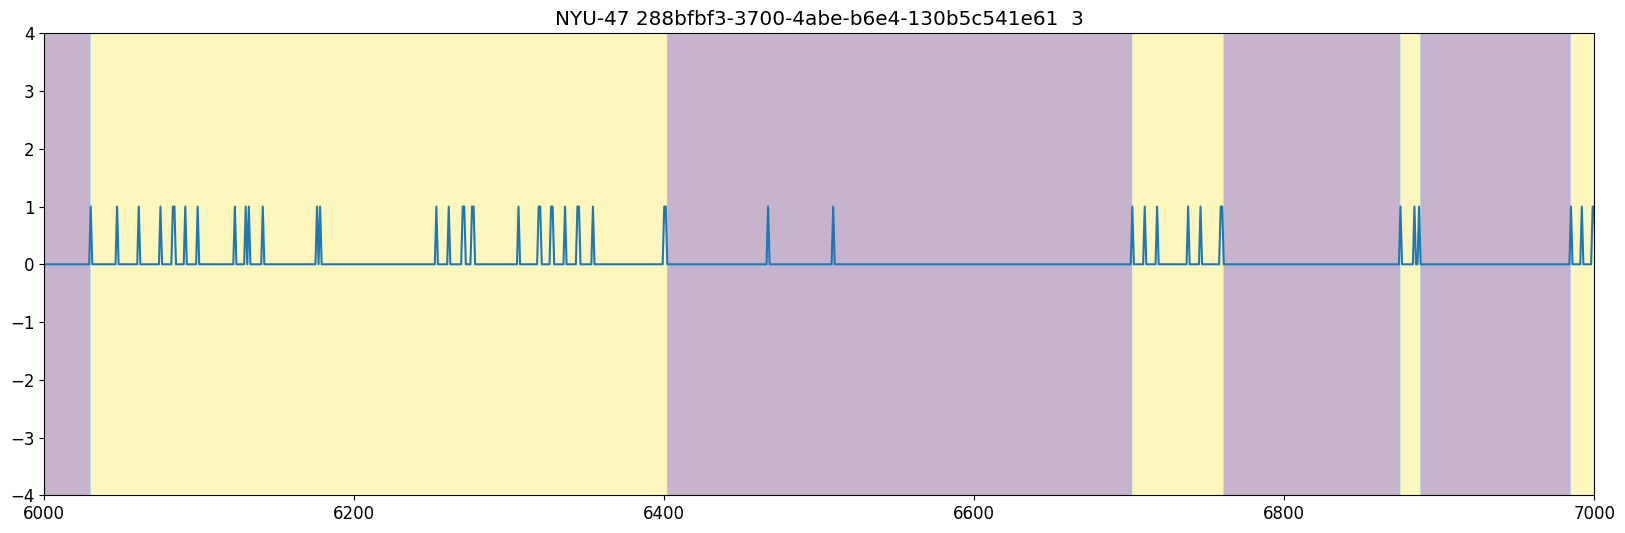

NYU-47288bfbf3-3700-4abe-b6e4-130b5c541e61


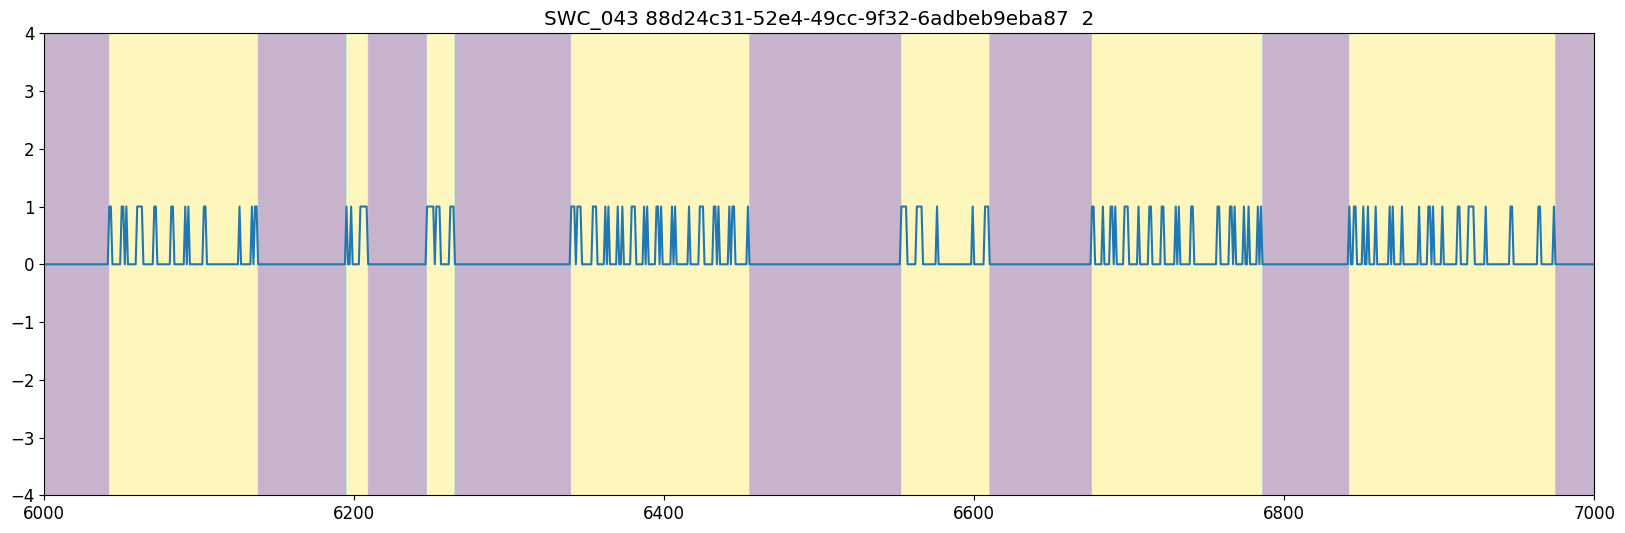

SWC_04388d24c31-52e4-49cc-9f32-6adbeb9eba87


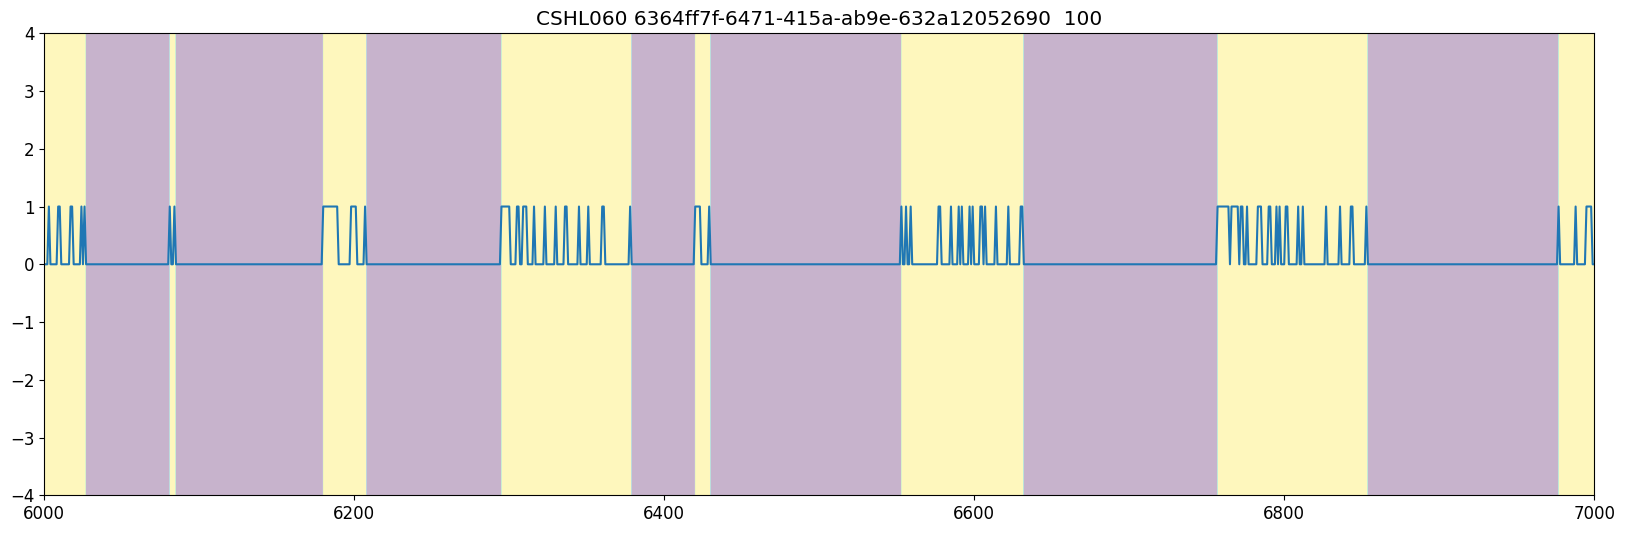

CSHL0606364ff7f-6471-415a-ab9e-632a12052690


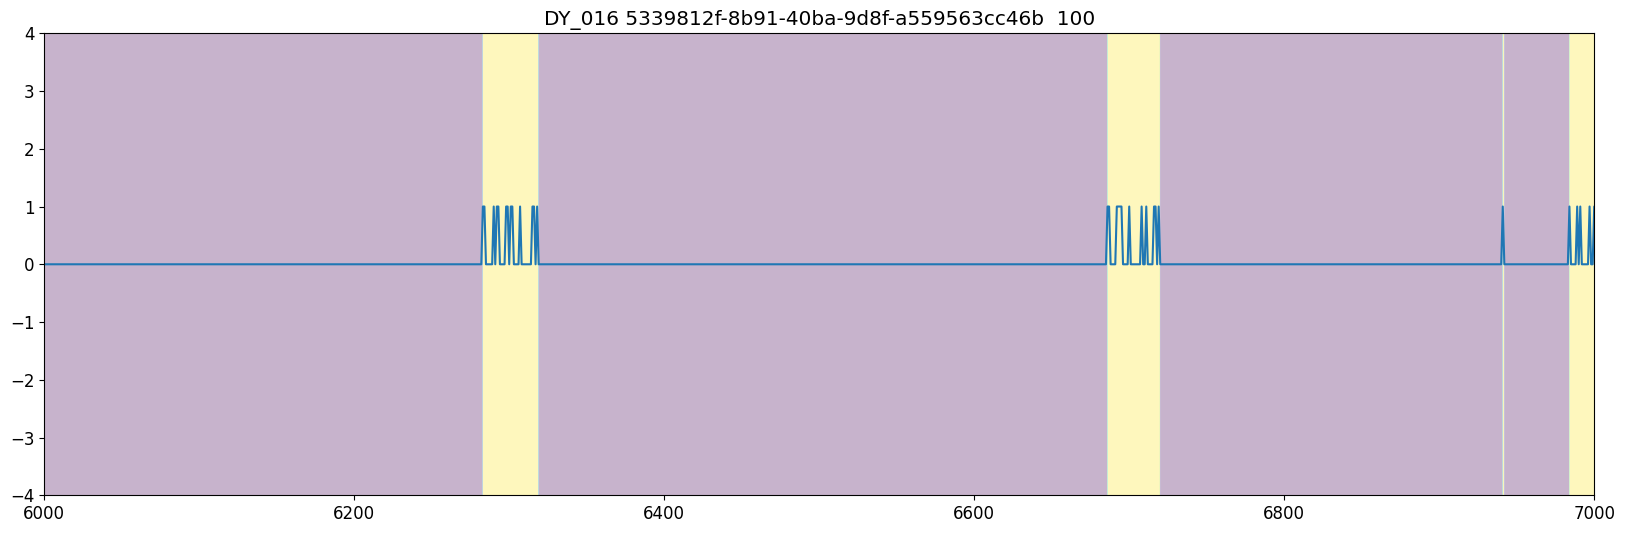

DY_0165339812f-8b91-40ba-9d8f-a559563cc46b


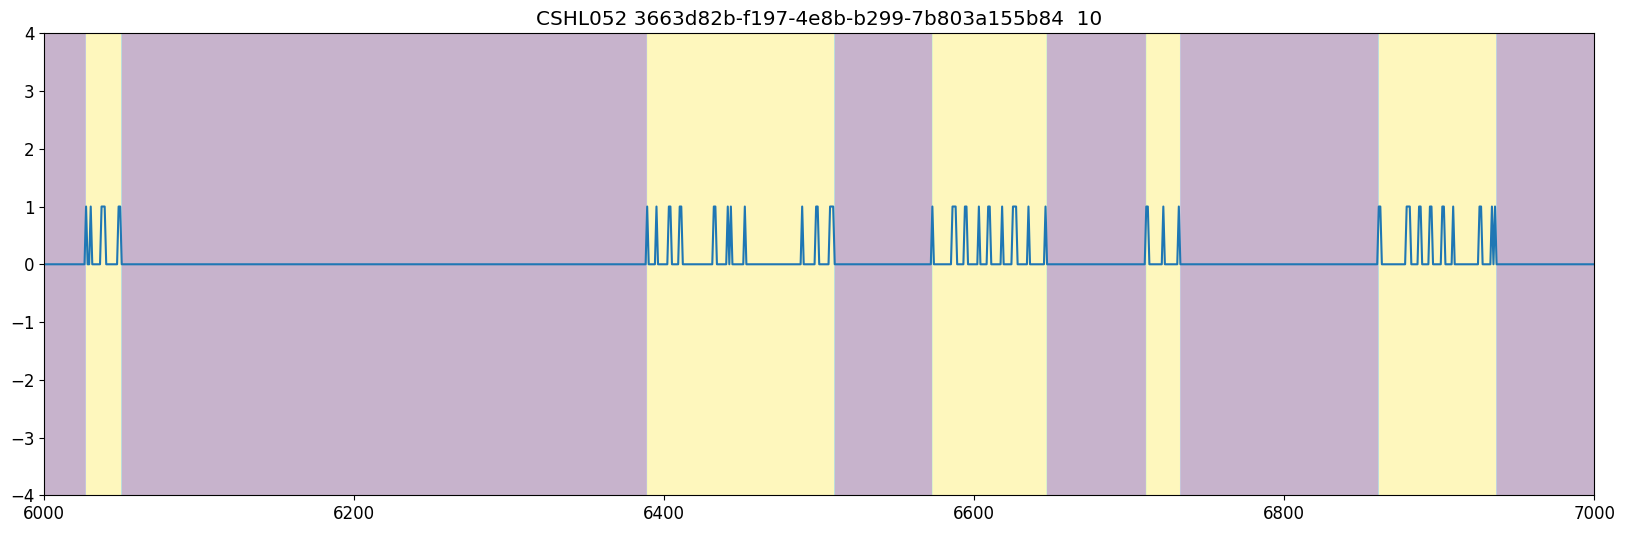

CSHL0523663d82b-f197-4e8b-b299-7b803a155b84


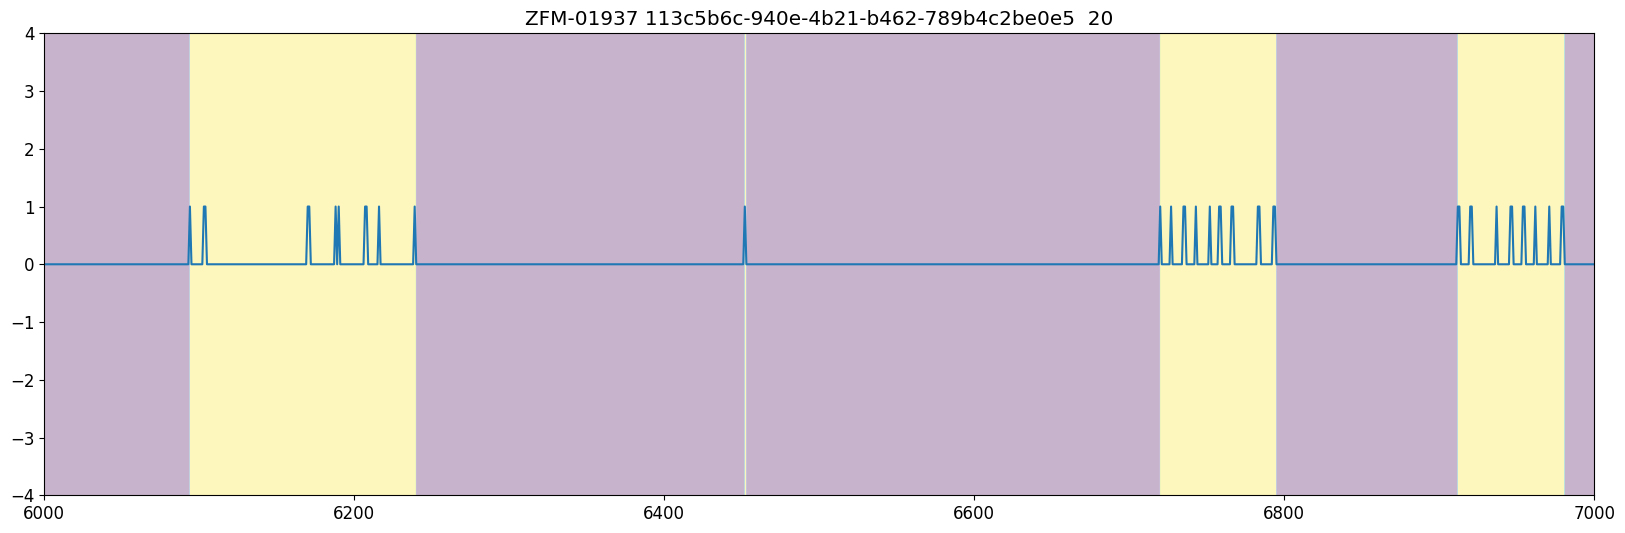

ZFM-01937113c5b6c-940e-4b21-b462-789b4c2be0e5


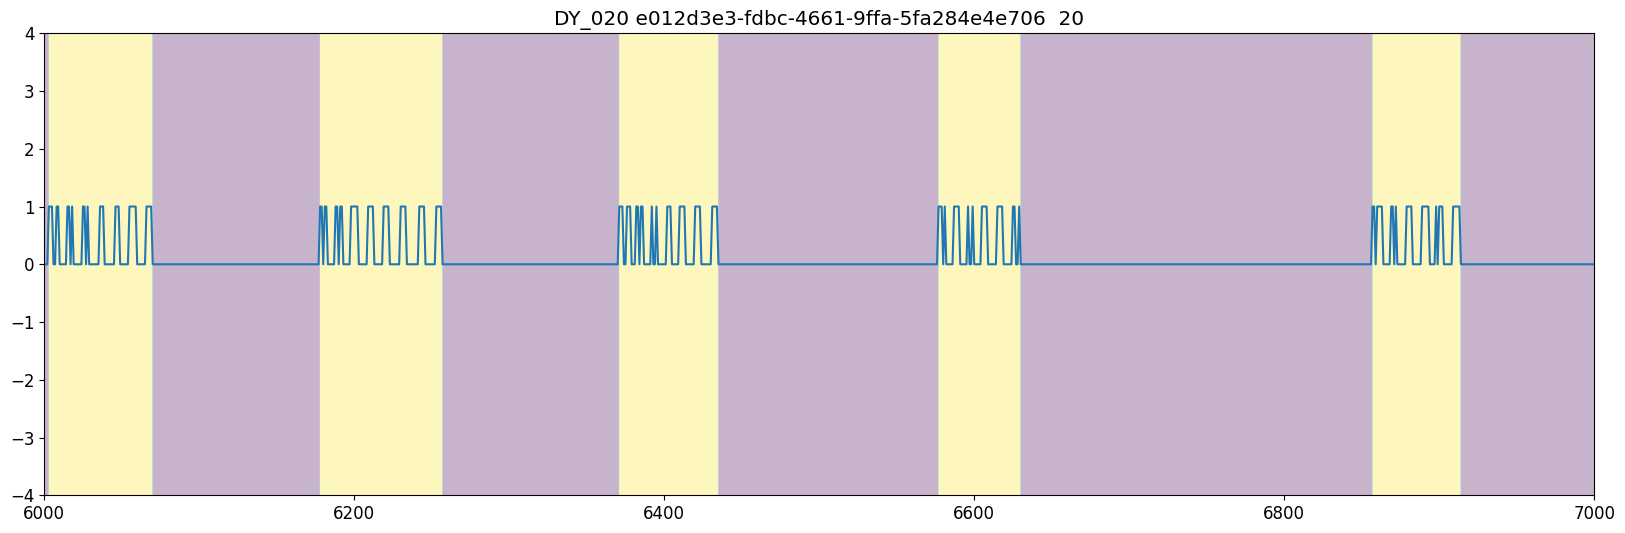

DY_020e012d3e3-fdbc-4661-9ffa-5fa284e4e706


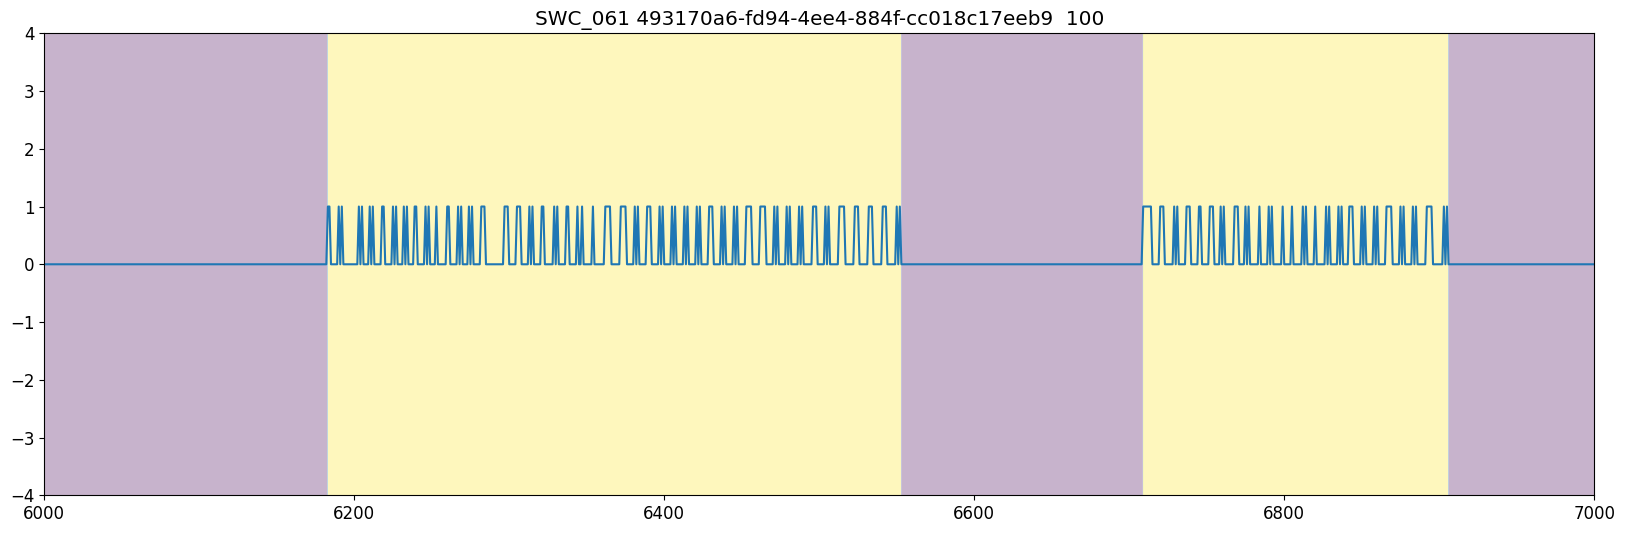

SWC_061493170a6-fd94-4ee4-884f-cc018c17eeb9


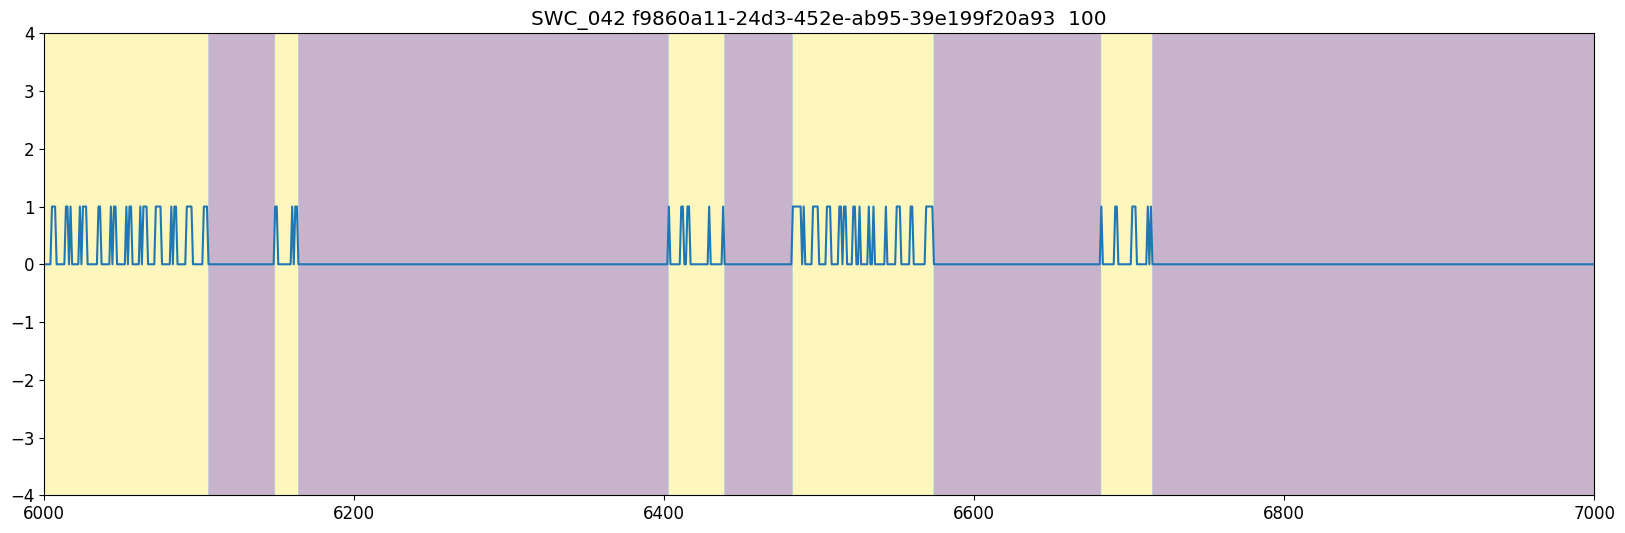

SWC_042f9860a11-24d3-452e-ab95-39e199f20a93


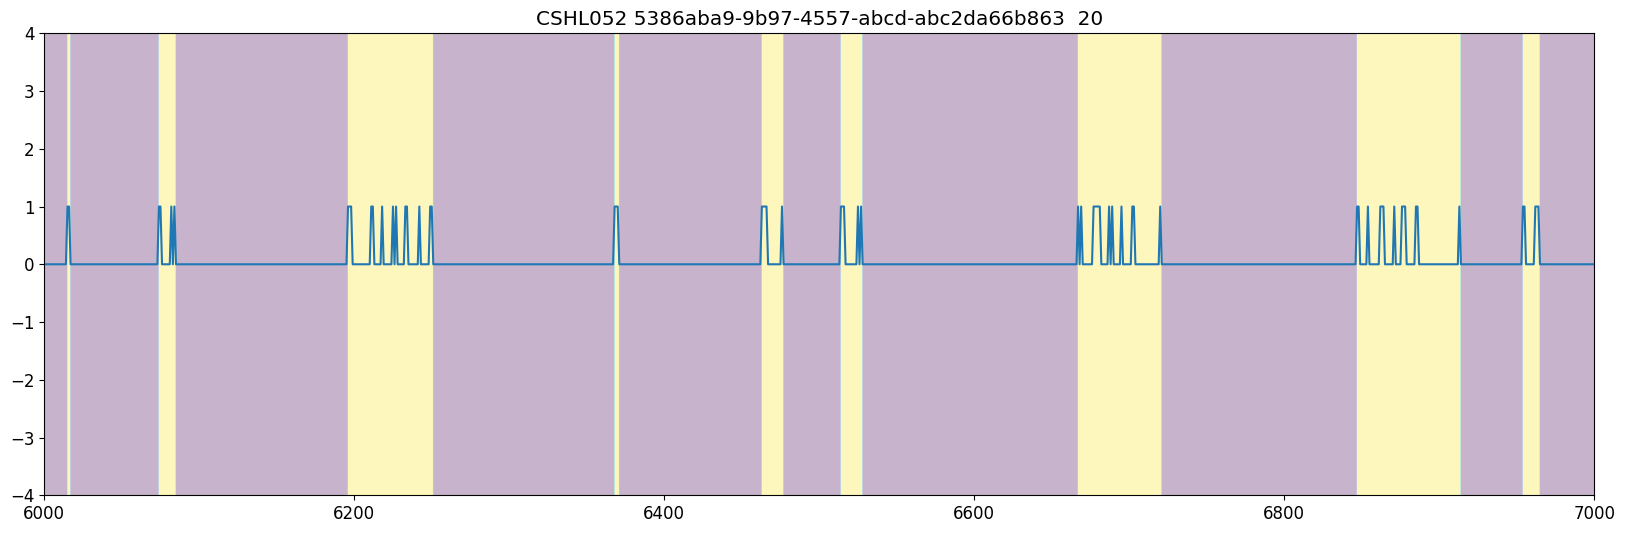

CSHL0525386aba9-9b97-4557-abcd-abc2da66b863


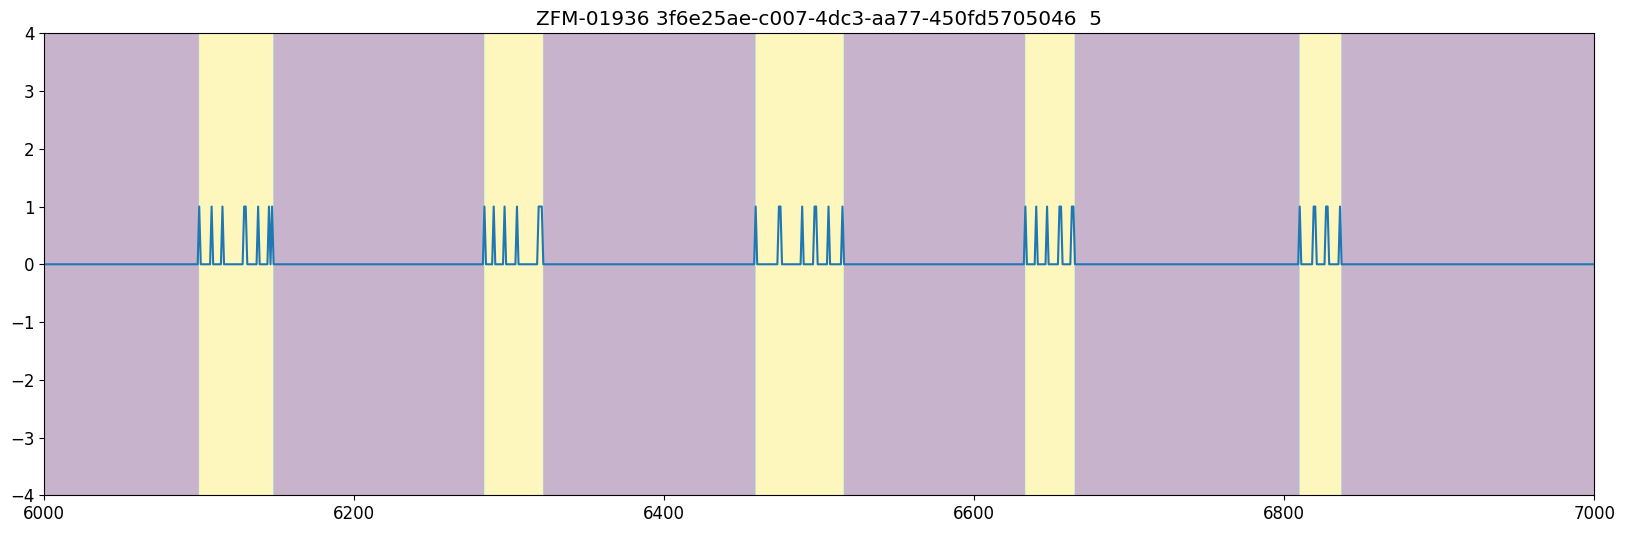

ZFM-019363f6e25ae-c007-4dc3-aa77-450fd5705046


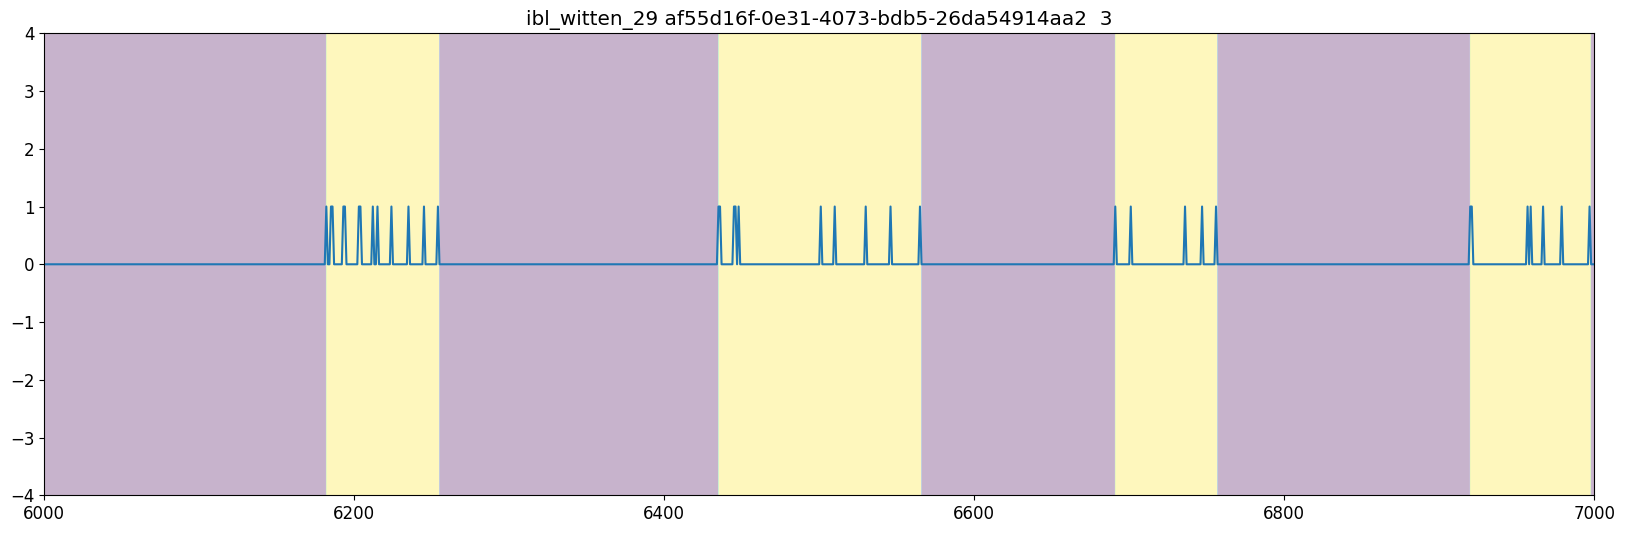

ibl_witten_29af55d16f-0e31-4073-bdb5-26da54914aa2


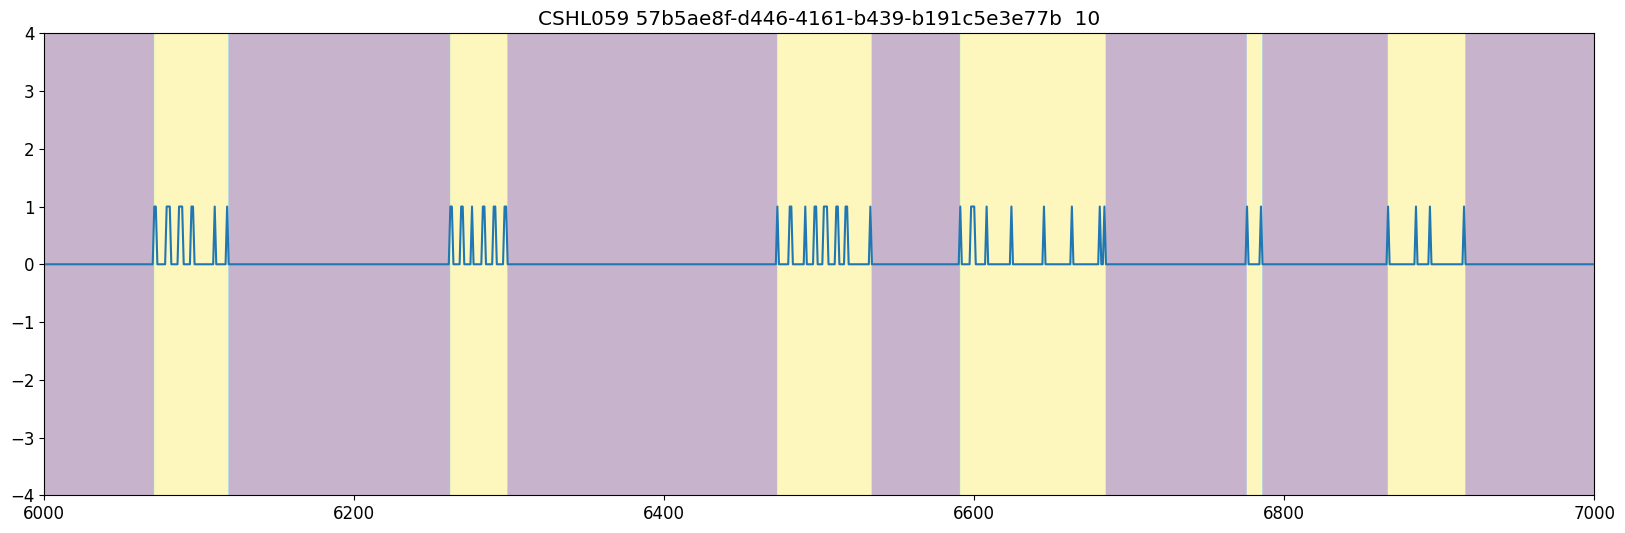

CSHL05957b5ae8f-d446-4161-b439-b191c5e3e77b


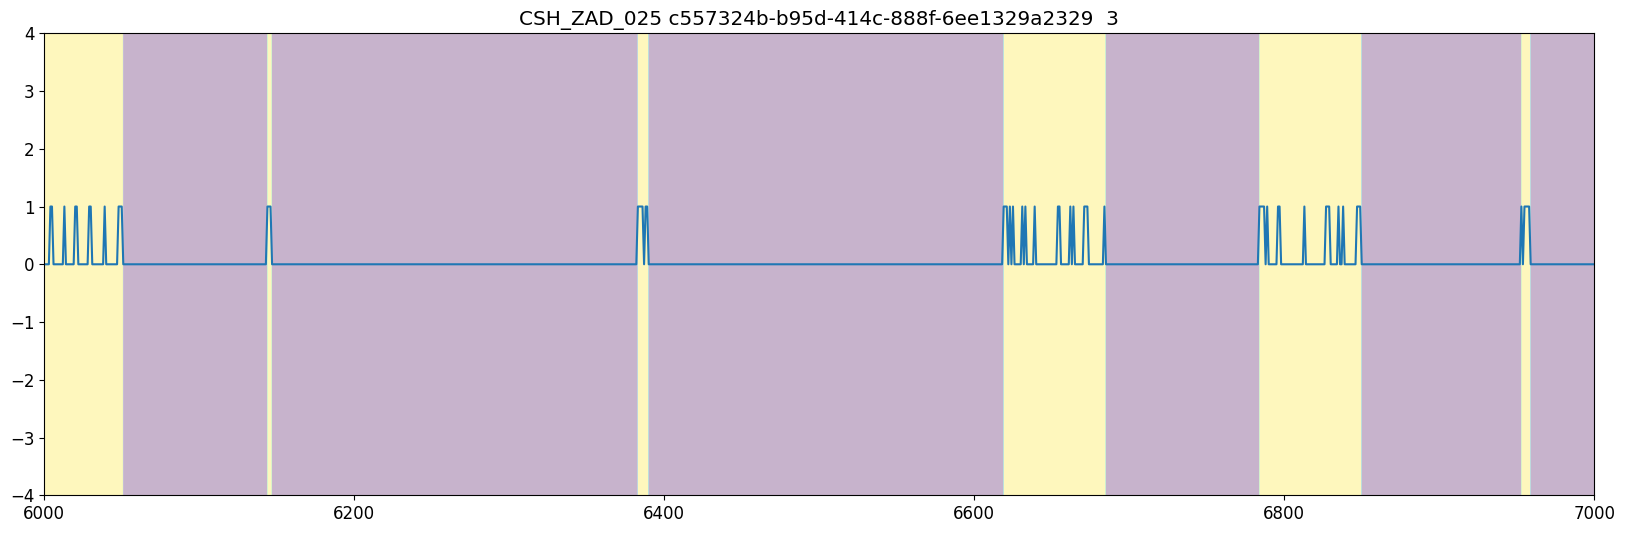

CSH_ZAD_025c557324b-b95d-414c-888f-6ee1329a2329


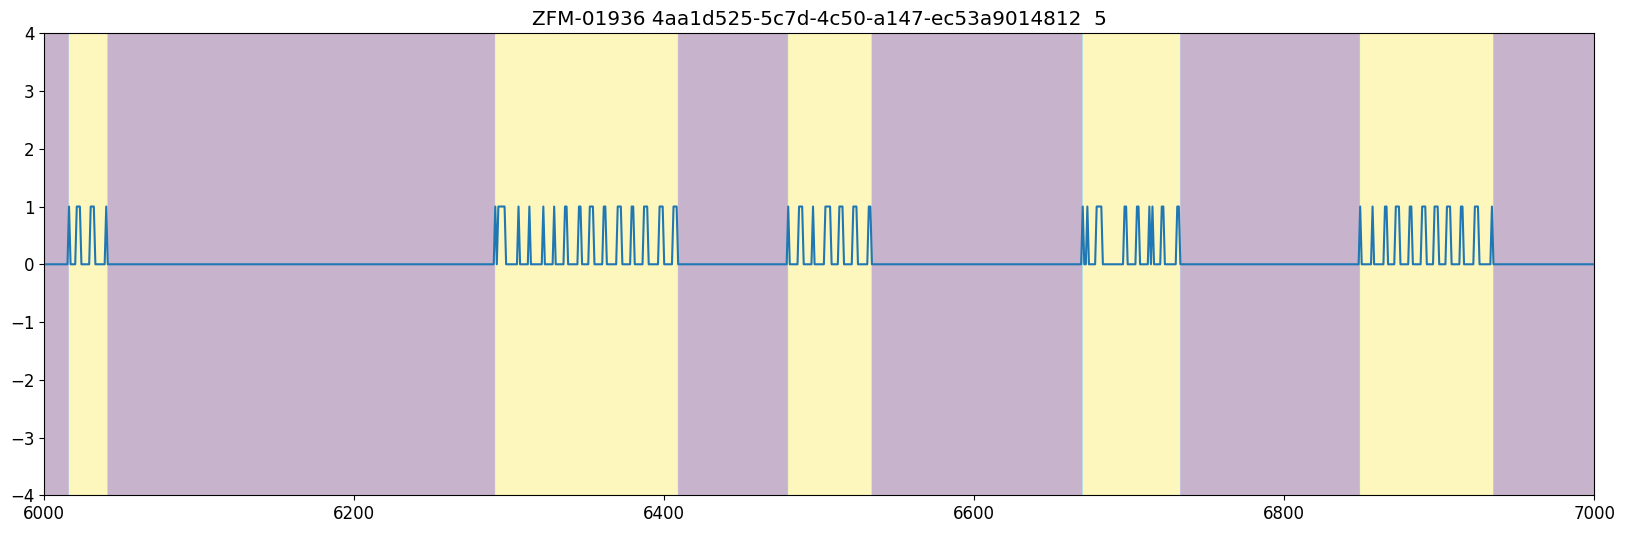

ZFM-019364aa1d525-5c7d-4c50-a147-ec53a9014812


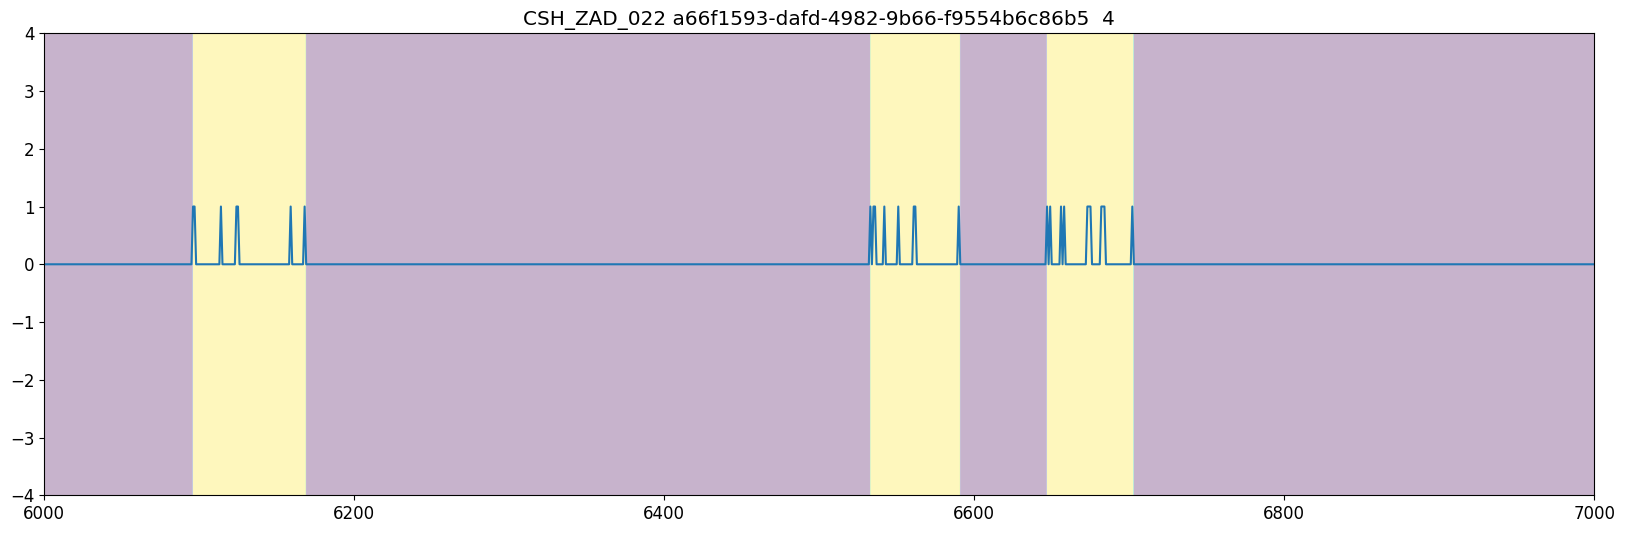

CSH_ZAD_022a66f1593-dafd-4982-9b66-f9554b6c86b5


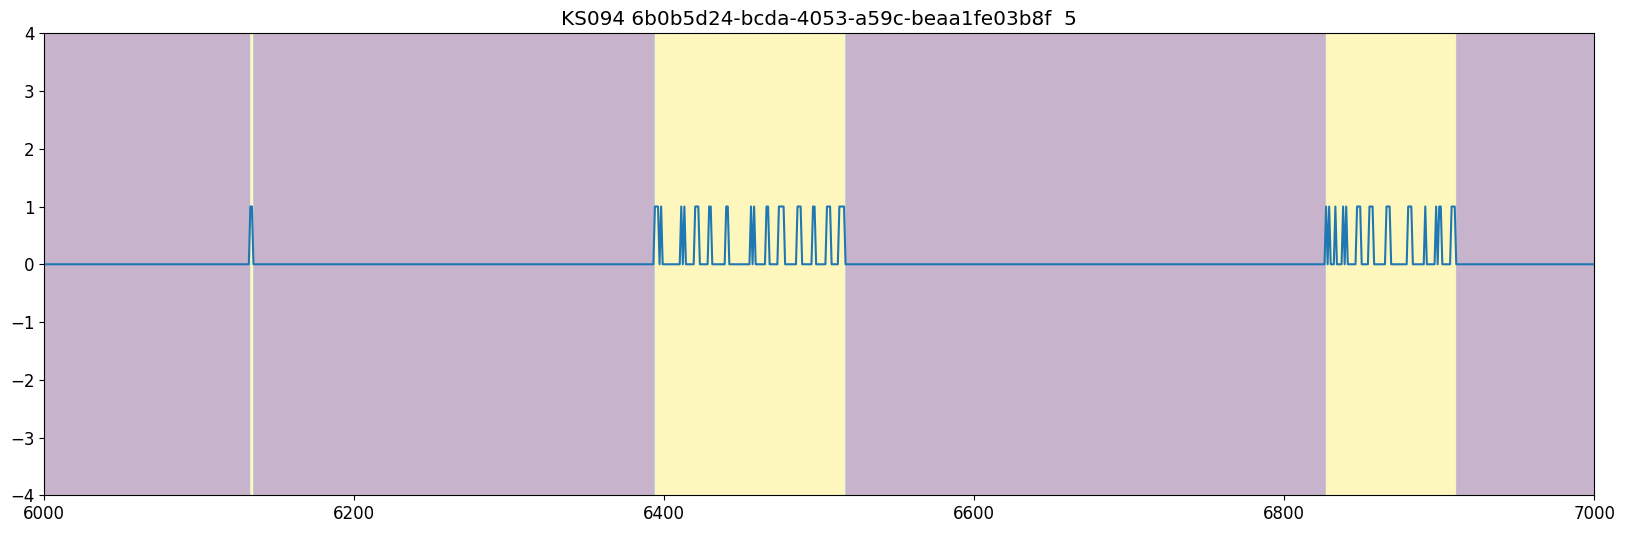

KS0946b0b5d24-bcda-4053-a59c-beaa1fe03b8f


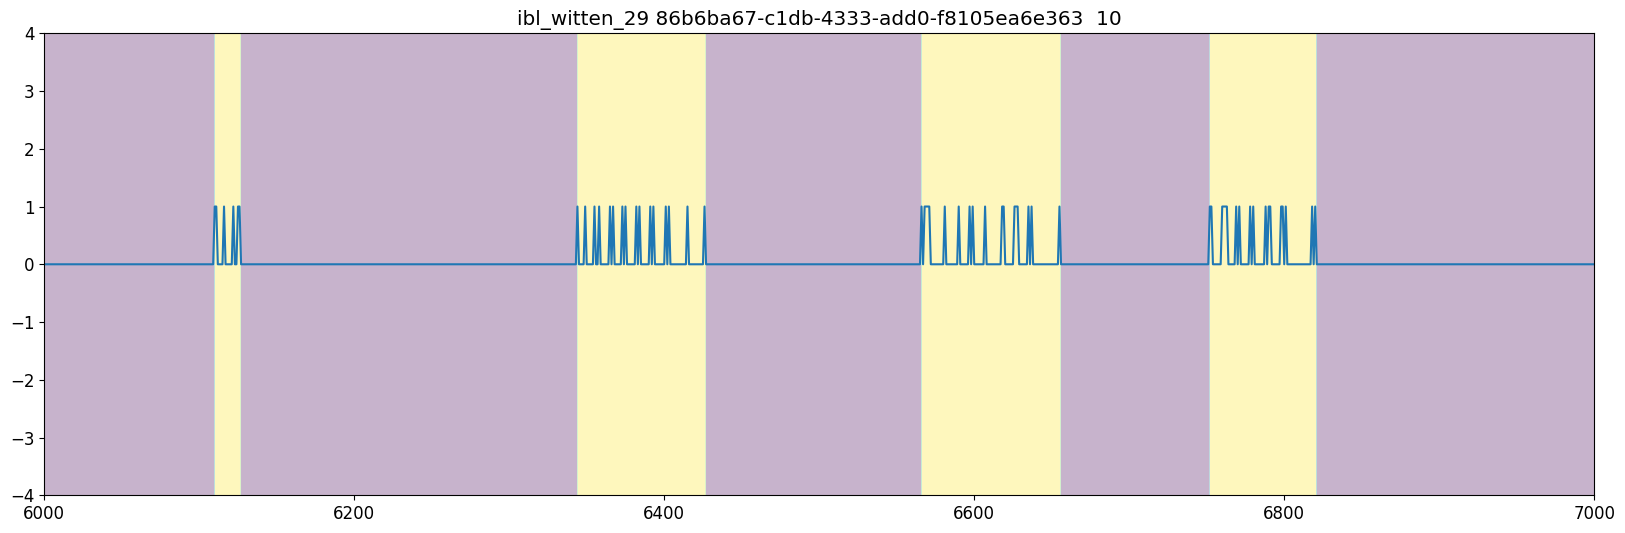

ibl_witten_2986b6ba67-c1db-4333-add0-f8105ea6e363


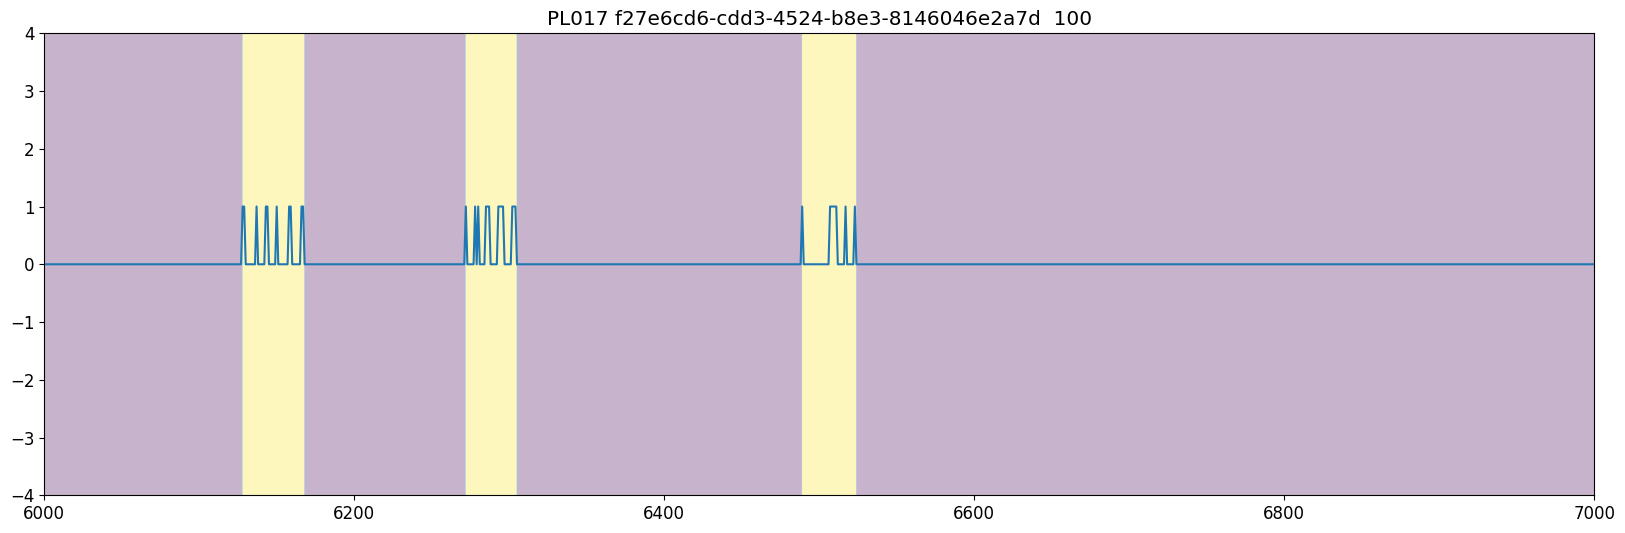

PL017f27e6cd6-cdd3-4524-b8e3-8146046e2a7d


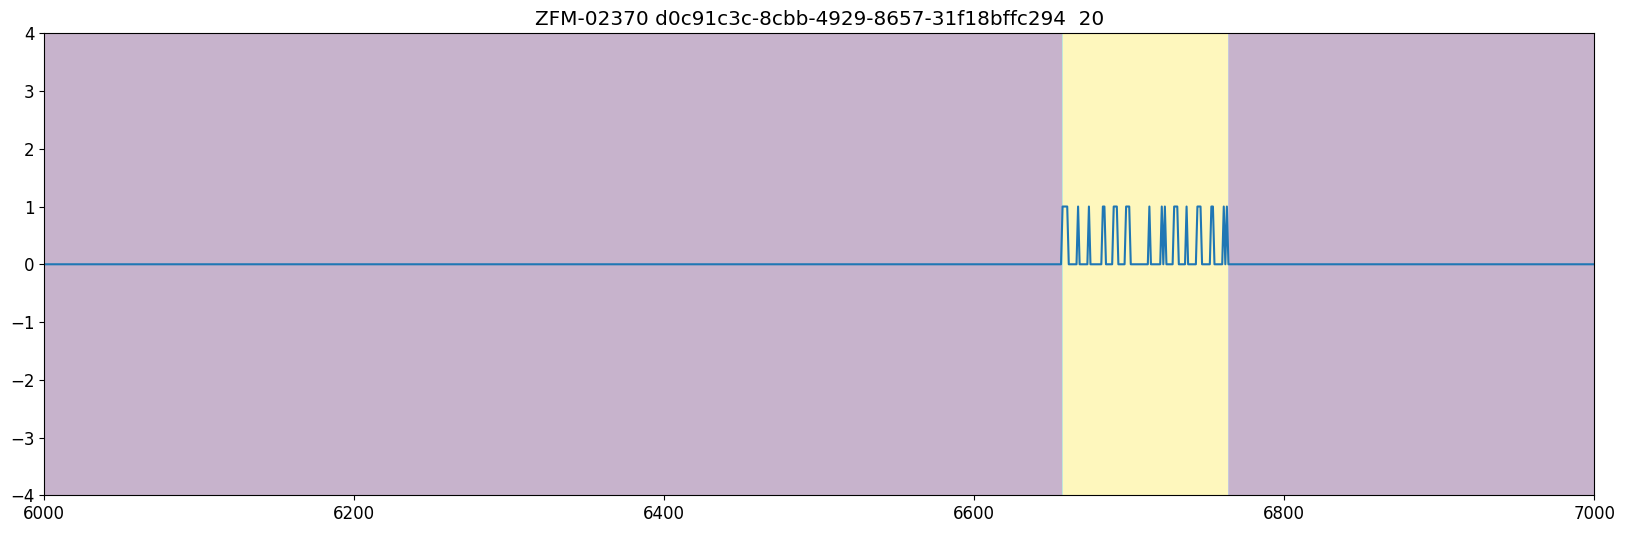

ZFM-02370d0c91c3c-8cbb-4929-8657-31f18bffc294


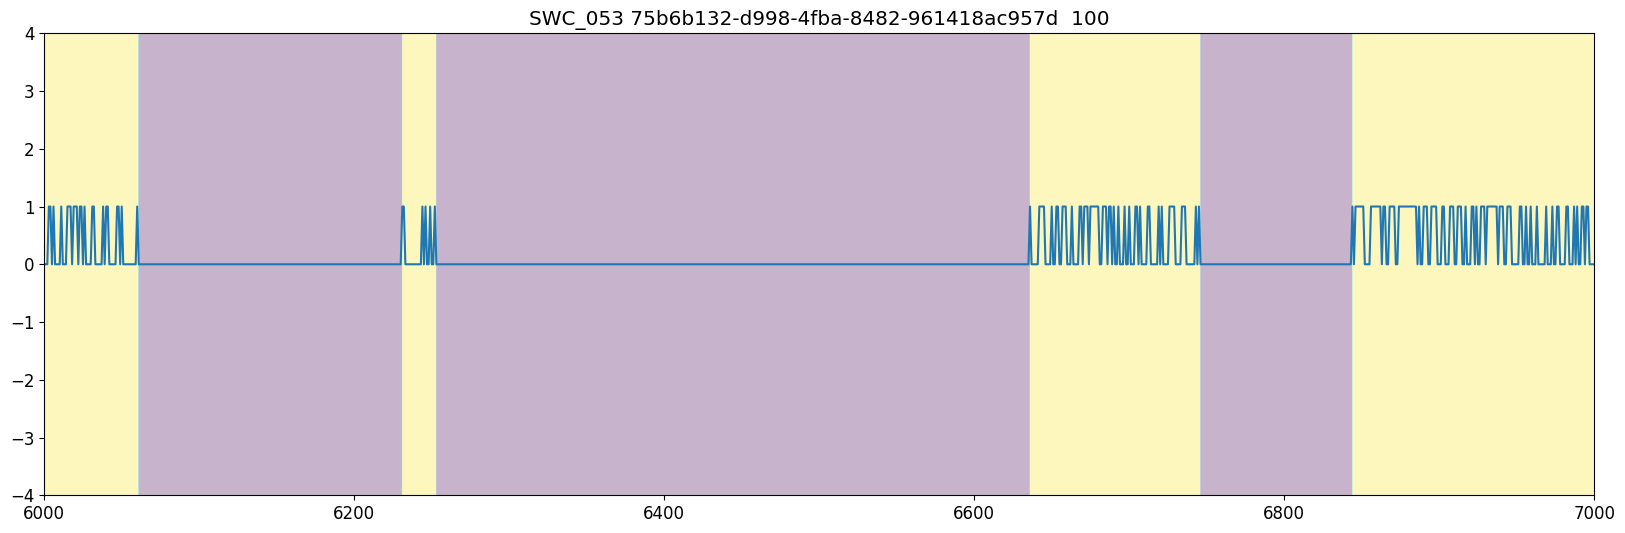

SWC_05375b6b132-d998-4fba-8482-961418ac957d


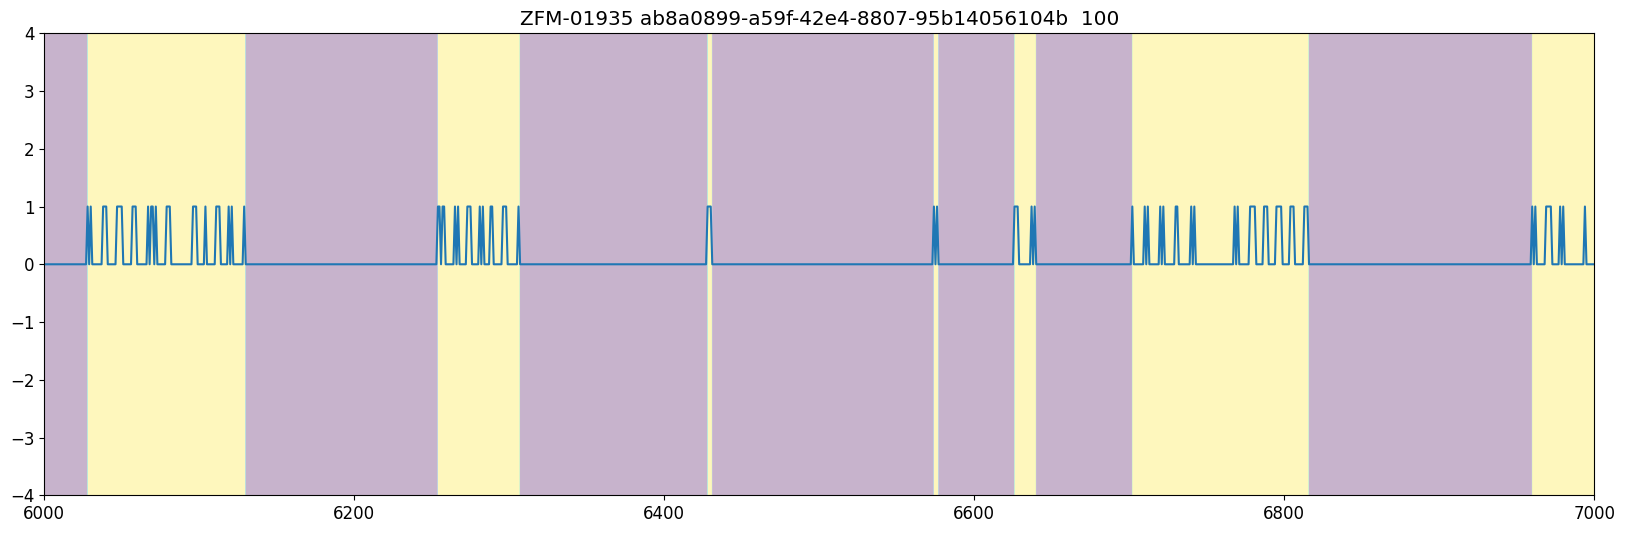

ZFM-01935ab8a0899-a59f-42e4-8807-95b14056104b


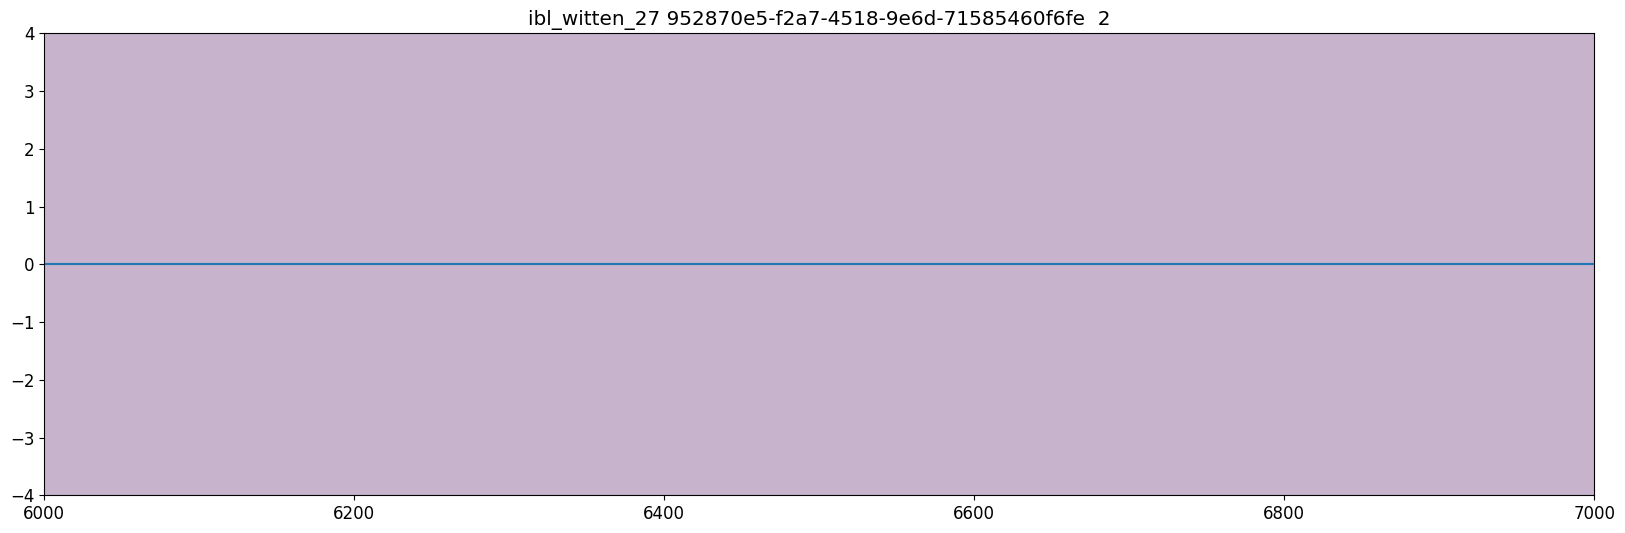

ibl_witten_27952870e5-f2a7-4518-9e6d-71585460f6fe


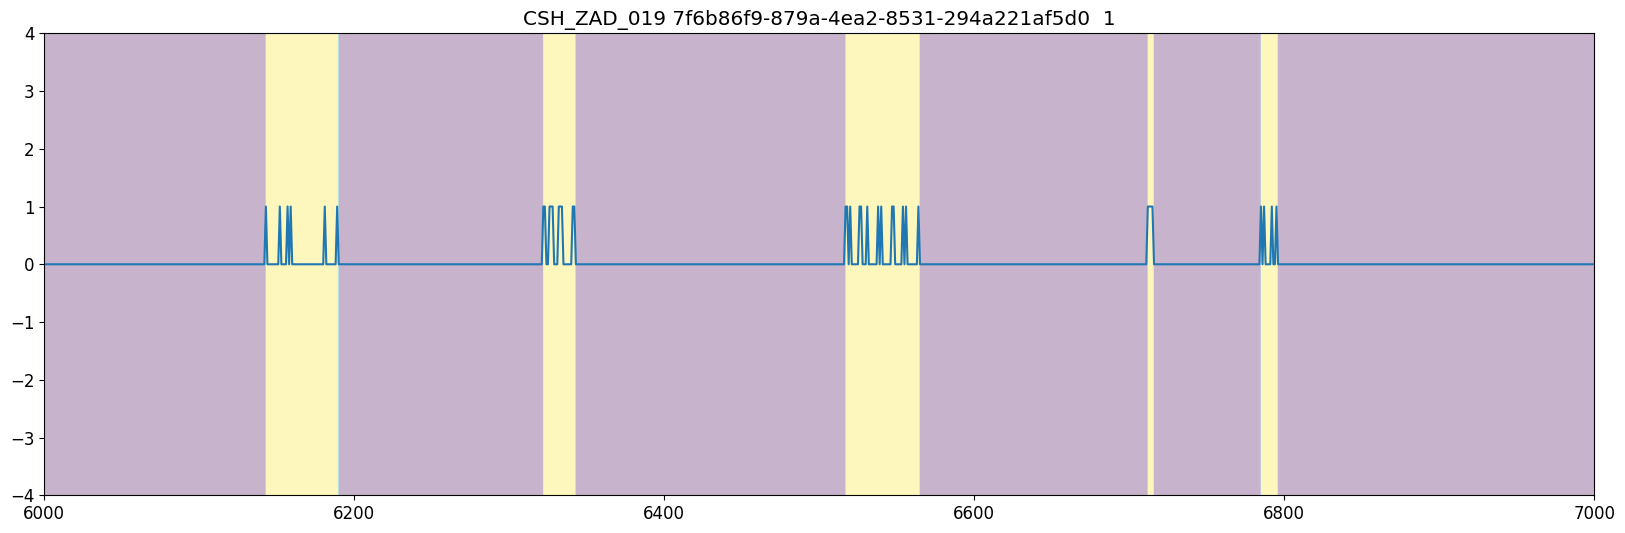

CSH_ZAD_0197f6b86f9-879a-4ea2-8531-294a221af5d0


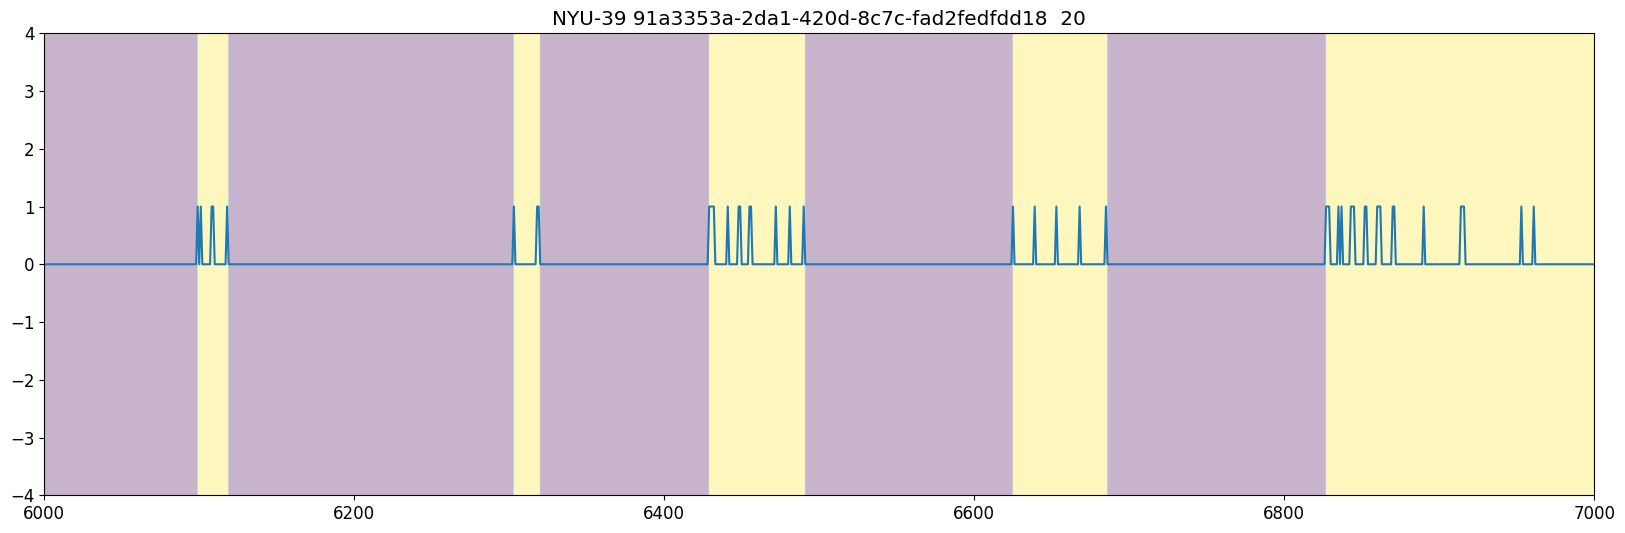

NYU-3991a3353a-2da1-420d-8c7c-fad2fedfdd18


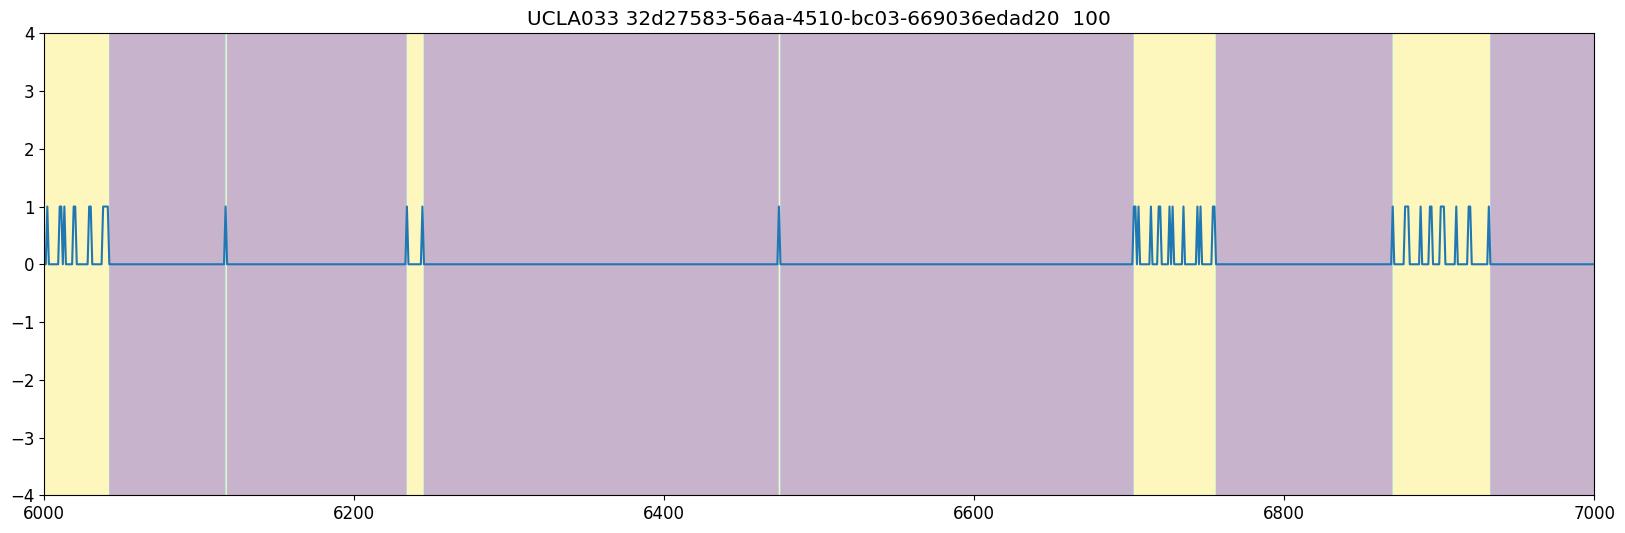

UCLA03332d27583-56aa-4510-bc03-669036edad20


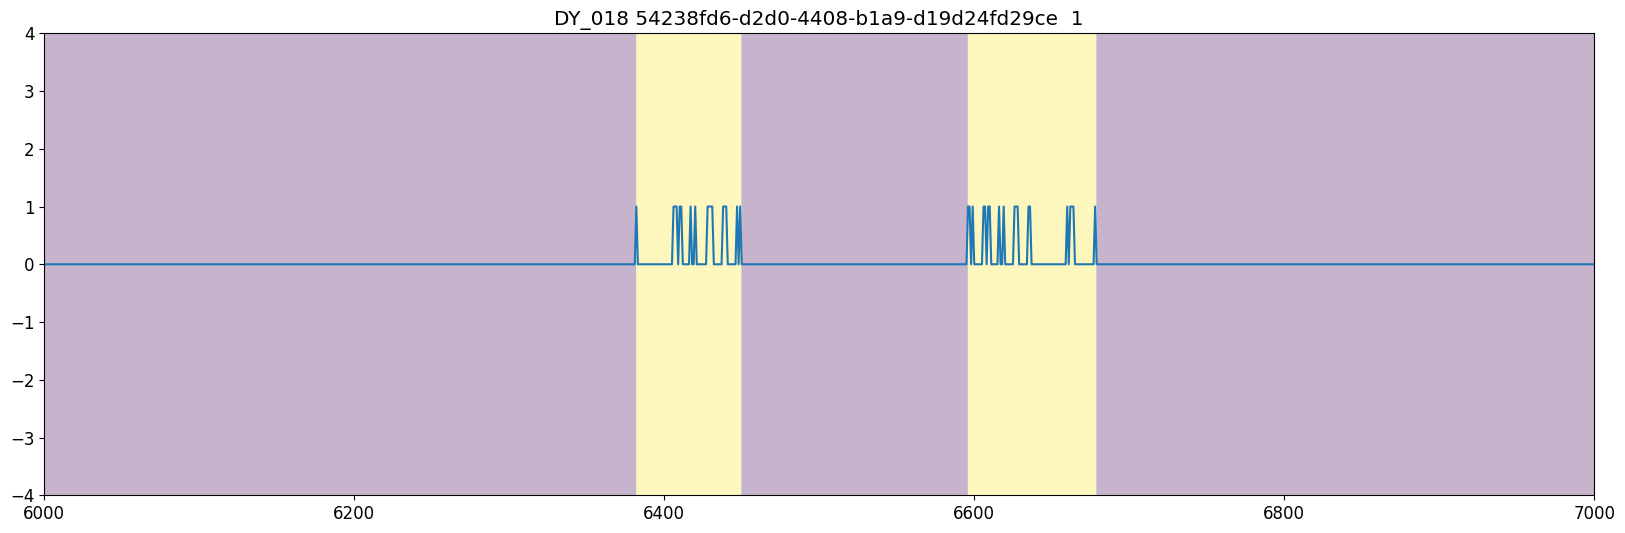

DY_01854238fd6-d2d0-4408-b1a9-d19d24fd29ce


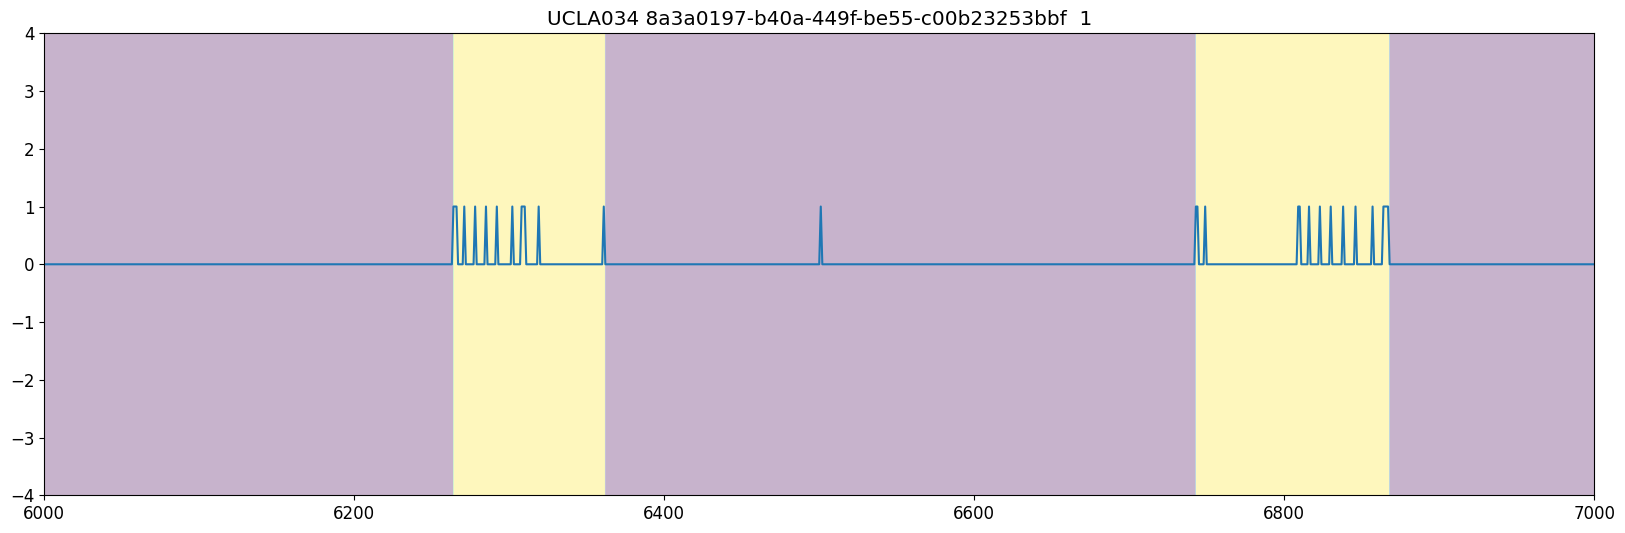

UCLA0348a3a0197-b40a-449f-be55-c00b23253bbf


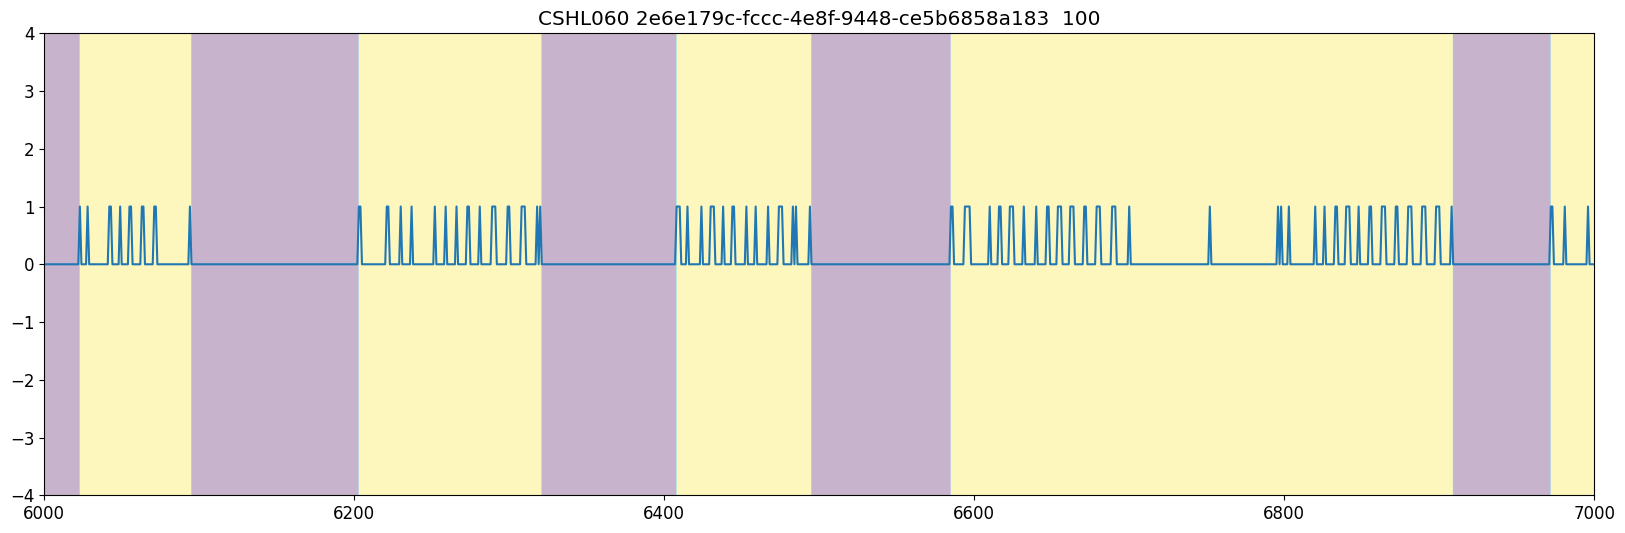

CSHL0602e6e179c-fccc-4e8f-9448-ce5b6858a183


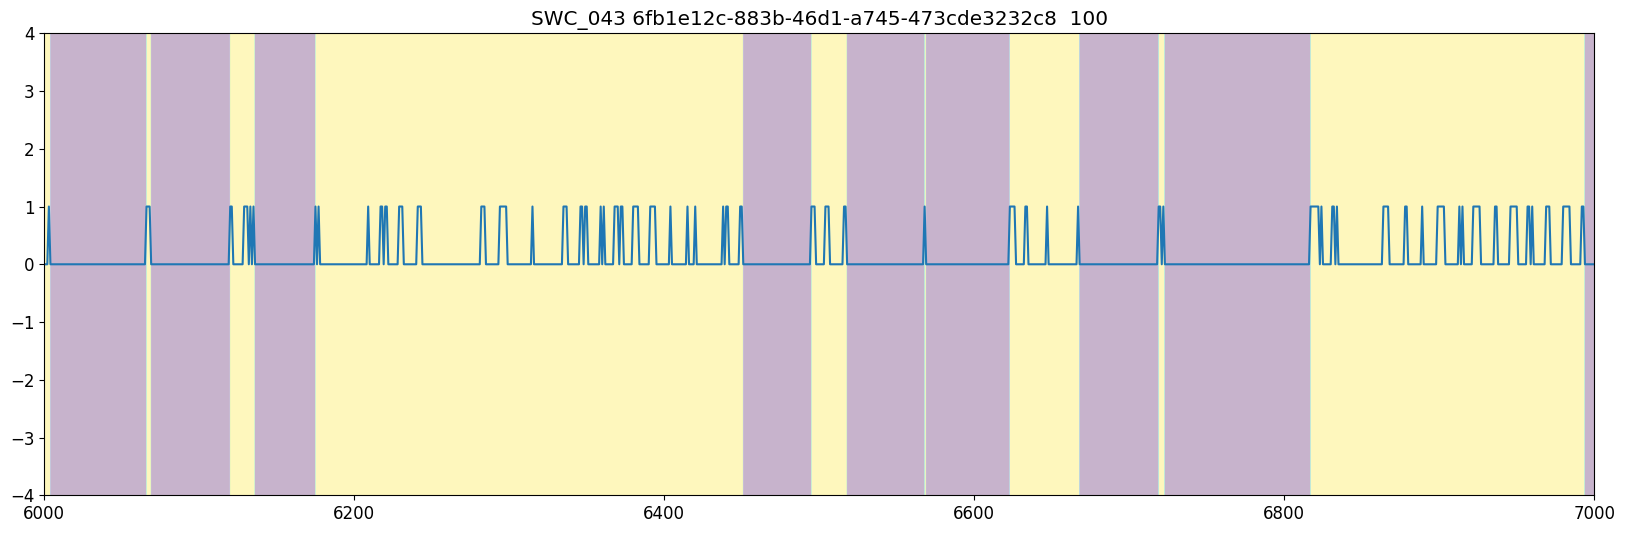

SWC_0436fb1e12c-883b-46d1-a745-473cde3232c8


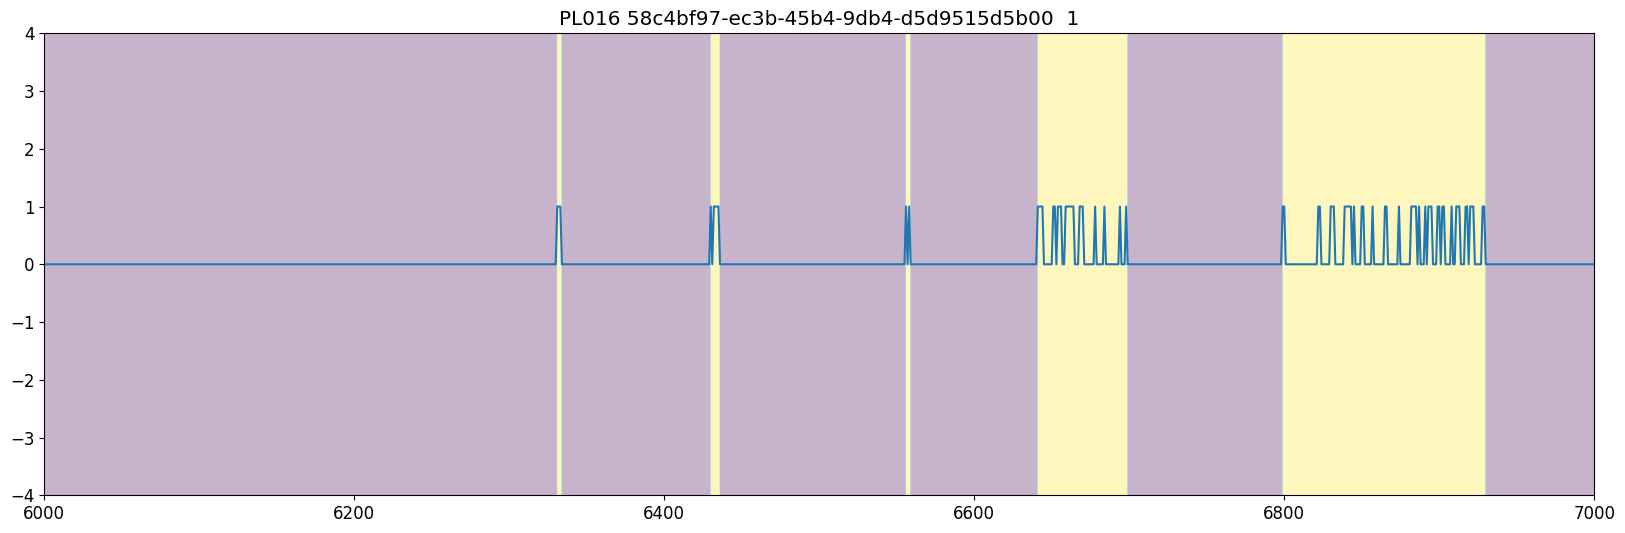

PL01658c4bf97-ec3b-45b4-9db4-d5d9515d5b00


In [5]:
index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
idx_init = idx_init_list[index_var]
idx_end = idx_end_list[index_var]
var_names = use_sets[index_var]

fit = False
kappa=100
num_train_batches = 5
num_states=2
smooth = False
window=6
downsample=False
downsample_factor=10

for m, mat in enumerate(sessions_to_process): 
    
    mouse_name = mat[0]
    session = mat[1]
    # mouse_name = 'NYU-11'
    # session = '56956777-dca5-468c-87cb-78150432cc57'
    
    # mouse_name = 'ZFM-02372'
    # session = '88224abb-5746-431f-9c17-17d7ef806e6a'
    fit_id = str(mouse_name+session)
    
    # Get session data
    filename = data_path + "session_trials_" + str(session) + '_'  + mouse_name
    session_trials = pd.read_parquet(filename, engine='pyarrow').reset_index()  # I think resetting index is what gives the trial number?
    # Get design_matrix
    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    unnorm_design_matrix =  pd.read_parquet(filename, engine='pyarrow').dropna().reset_index()
    # Get standardized design_matrix
    filename = data_path + "standardized_design_matrix_" + str(session) + '_'  + mouse_name
    standardized_designmatrix = np.load(filename+str('.npy'))
    filtered_matrix = standardized_designmatrix[~np.isnan(standardized_designmatrix).any(axis=1)]  # Need to dropnans
    design_matrix = filtered_matrix.copy()[:, idx_init:idx_end]
    
    num_timesteps = np.shape(design_matrix)[0]

    if fit:
        # Prepare data format
        emission_dim = np.shape(design_matrix)[1]
        data = design_matrix[:(num_timesteps // num_train_batches) * num_train_batches]
        # data = np.array(unnorm_design_matrix[var_names])[:(num_timesteps // num_train_batches) * num_train_batches].reshape(-1, 1)
        if smooth:
            df = pd.DataFrame(data, columns=["Signal"])
            smoothed_signal = df["Signal"].rolling(window=window, center=True).mean().to_numpy()
            shortened_array = np.array(data)
            shortened_array[int(np.ceil(window/2)):-int(np.floor(window/2))] = smoothed_signal[int(np.ceil(window/2)):-int(np.floor(window/2))].reshape(-1, 1)
        else:
            shortened_array = np.array(data)        
        
        if downsample:
            # Downsample
            downsampled = shortened_array[::downsample_factor].copy()
            shortened_array = downsampled[:(np.shape(downsampled)[0] // num_train_batches) * num_train_batches]

        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
        
        " Fit model with best params"
        # Initialize new hmm and fit
        pois_hmm = PoissonHMM(num_states, emission_dim, transition_matrix_stickiness=kappa)

        # init_params, props = arhmm.initialize(key=jr.PRNGKey(0), method=method, emissions=shortened_array)  # not sure if I need to include  
        all_val_lls, fit_params, init_params, baseline_lls = cross_validate_poismodel(
                            pois_hmm, jr.PRNGKey(0), train_emissions, num_train_batches, method='em'
                        )
        # Find parameters for best fold
        # use_fold = np.argmax(all_val_lls)
        use_fold = np.where(all_val_lls == np.nanmax(all_val_lls))[0][0]
        initial_probs = fit_params[0].probs[use_fold]
        transition_matrix = fit_params[1].transition_matrix[use_fold]
        emission_rates = fit_params[2].rates[use_fold]
     
        # Initialize new hmm
        new_poishmm = PoissonHMM(num_states, emission_dim, transition_matrix_stickiness=kappa)
        best_fold_params, props = new_poishmm.initialize(key=jr.PRNGKey(0), 
                                        initial_probs=initial_probs,
                                        transition_matrix=transition_matrix,
                                        emission_rates=emission_rates) #method=method,

        # Get state estimates for validation data
        most_likely_states = new_poishmm.most_likely_states(best_fold_params, shortened_array)
        # most_likely_states = arhmm.most_likely_states(init_params, shortened_array, my_inputs)

    else:
        # Get most likely states
        result_filename = os.path.join(cv_results_path  + "most_likely_states" + var_interest + '_' + fit_id)
        most_likely_states, use_fold, best_params = pickle.load(open(result_filename, "rb"))
        state_numer, _, kappa_number = best_params
    
    " Plots "
    # Prepare data
    design_matrix_heading = pd.DataFrame(columns=var_names)
    design_matrix_heading[var_names] = design_matrix[0:len(most_likely_states)]  # TODO: need to understand why number is the same and whether it depends on lag
    bins = unnorm_design_matrix[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
    design_matrix_heading['Bin'] = bins
    
    if smooth:
        data = design_matrix_heading[var_names].rolling(window=window, center=True).median()
    else:
        data = design_matrix_heading[var_names]
        
    # Plot raw trace over states
    fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 6])
    plt.rc('font', size=12)
    ax.plot(data)
    ax.imshow(np.concatenate([most_likely_states])[None,:], 
                extent=(0, len(np.concatenate([most_likely_states])), -4, 4),
                aspect="auto",
                cmap='viridis',
                alpha=0.3) 
    if fit:
        ax.set_title(mouse_name+' '+session+' '+' '+str(kappa))
    else:
        ax.set_title(mouse_name+' '+session+' '+' '+str(kappa_number))
    init = 6000
    ax.set_xlim([init, init+1000])
    plt.show()
    print(fit_id)
    